In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from utils.class_weights import get_normalized_class_weights
from utils.model_evaluate import ModelEvaluator

In [2]:
df = pd.read_csv('../data/02_handling_outliers/data.csv')
print(df.shape)

df.head()

(22742, 14)


,user,sexo,uf,idade,dias,pviews,visitas,tempo_total,device,blog_cartola,cartola_status,horas_engajamento_futebol,horas_engajamento_outros_esportes,horas_engajamento_home
0,1919933,NaN,NaN,NaN,1,1,1,0.012500,m_only,0.012500,cartola_free,0.000000,0.000000,0.000000
1,1979452,NaN,NaN,NaN,7,66,10,1.018757,pc_e_m,0.068122,cartola_pro,0.911605,0.000000,0.026530
2,1987950,NaN,NaN,NaN,7,14,6,1.293761,pc_e_m,0.012500,cartola_free,0.000000,0.564663,0.025642
3,1988149,NaN,NaN,NaN,8,49,24,1.995802,pc_only,0.013103,cartola_free,0.357694,0.961152,0.651353
4,1996199,NaN,NaN,NaN,21,75,46,2.845341,pc_e_m,0.026424,cartola_free,0.335683,1.996365,0.219123


Atribuindo labels ao target

In [3]:
df.loc[df['cartola_status'] == 'cartola_free', 'target_cartola_status'] = 0
df.loc[df['cartola_status'] == 'cartola_pro', 'target_cartola_status'] = 1
df.drop(columns=['cartola_status'], inplace=True)

In [4]:
df['target_cartola_status'].value_counts(normalize=True) * 100

target_cartola_status
0.0    97.388093
1.0     2.611907
Name: proportion, dtype: float64

Vamos utilizar a correlação de Spearman, pois ela captura relações monotônicas (não apenas lineares) e é mais robusta a outliers

<Axes: >

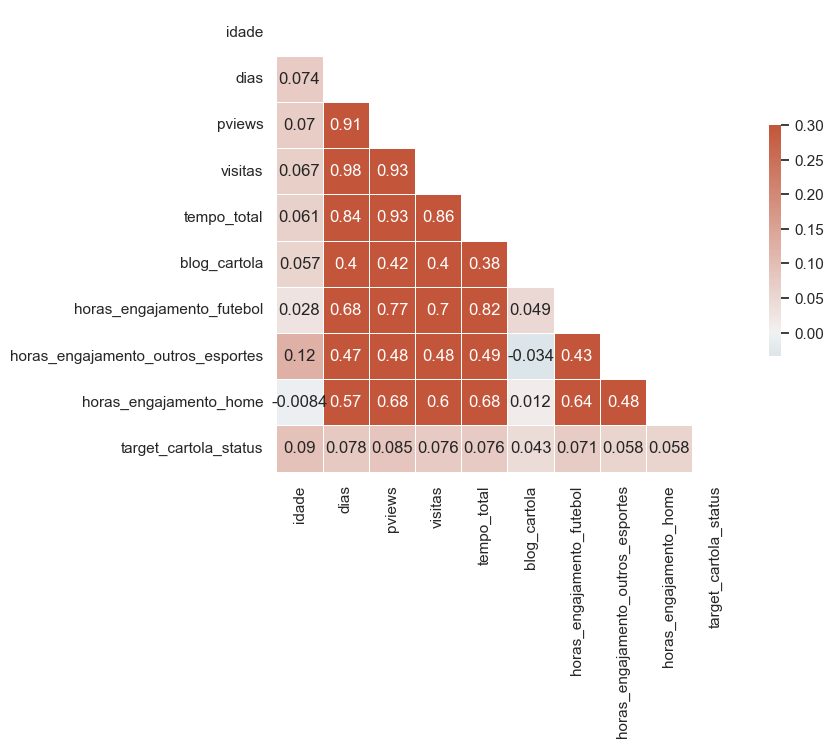

In [5]:
sns.set_theme(style="white")

corr = df.drop(columns=['user']).corr('spearman', numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(8, 6))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr
            , mask=mask
            , cmap=cmap
            , vmax=.3
            , center=0
            , square=True
            , linewidths=.5
            , cbar_kws={"shrink": .5}
            , annot=True)

Temos muitas features altamente correlatas, vamos reduzir algumas para evitar possível multicolinearidade

In [6]:
# taxa de engajamento
df['taxa_engajamento'] = df['tempo_total'] / df['visitas']

# razão entre a qtd de pviews por visitas
df['pviews_por_visitas'] = df['pviews'] / df['visitas']

# frequencia de visitas
df['frequencia_visitas'] = df['visitas'] / df['dias']

# Proporção de engajamento com futebol
# df['prop_engajamento_futebol'] = df['horas_engajamento_futebol'] / (df['horas_engajamento_outros_esportes'] + df['horas_engajamento_home'] + df['horas_engajamento_futebol'])

Dropando colunas que não serão mais utilizadas

- coluna UF: Como vimos na análise exploratória, se não há diferença significativa na distribuição de clientes PRO e Free, a variável adiciona ruído sem valor preditivo
Também vamos evitar o problema de criar muitas variáveis dummy.
- coluna devices: vamos retirá-la, pois seu número de missings representa 50% do dataframe, o que pode comprometer a análise, até mesmo na hora de preenchê-los.
- coluna sexo: vimos na análise exploratória que o sexo masculino é predominante, e tbm notamos o alto nível de missing. Nessa primeira etapa, vou retirar essa variável,
  porém, vale a pena testa-la de outras formas futuramente, como por exemplo, imputar os valores nulos com um valor numérico (ex: -1) ou uma categoria representativa ('nao_atribuido').


In [7]:
drop_cols = ['pviews', 'visitas', 'dias', 'tempo_total', 'uf', 'sexo', 'device']
df = df.drop(columns=drop_cols)

In [8]:
# # Ver distribuição de device vs target
# df_with_device = df[df['device'].notna()]
# print(df_with_device.groupby(['device', 'target_cartola_status']).size().unstack())

# # Ver taxa de conversão por device
# conversion_by_device = df_with_device.groupby('device')['target_cartola_status'].mean()
# print("\nTaxa de conversão por device:")
# print(conversion_by_device)

# # Ver se há diferença significativa na conversão entre registros com e sem device
# has_device = df['device'].notna()
# print("\nTaxa de conversão:")
# print("Com device:", df[has_device]['target_cartola_status'].mean())
# print("Sem device:", df[~has_device]['target_cartola_status'].mean())

<Axes: >

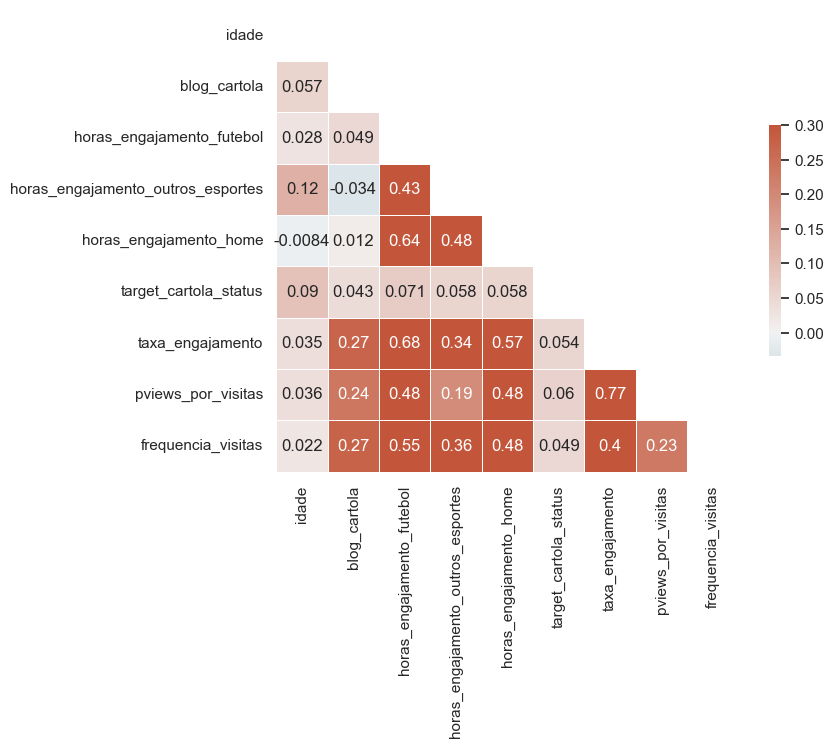

In [9]:
sns.set_theme(style="white")

corr = df.drop(columns=['user']).corr('spearman', numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(8, 6))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr
            , mask=mask
            , cmap=cmap
            , vmax=.3
            , center=0
            , square=True
            , linewidths=.5
            , cbar_kws={"shrink": .5}
            , annot=True)

Houve uma boa redução na correlação das variáveis.

In [10]:
df_test = df.sample(frac=.2, random_state=42) # separando 20% para teste

df_train_val = df.drop(df_test.index)

In [11]:
df_train_val.columns

Index(['user', 'idade', 'blog_cartola', 'horas_engajamento_futebol',
       'horas_engajamento_outros_esportes', 'horas_engajamento_home',
       'target_cartola_status', 'taxa_engajamento', 'pviews_por_visitas',
       'frequencia_visitas'],
      dtype='object')

In [12]:
X = df_train_val.drop(columns=['user', 'target_cartola_status'])
y = df_train_val['target_cartola_status']

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Define as colunas para cada tipo de transformação
cols_num = [
    'idade',
    'taxa_engajamento',
    'pviews_por_visitas',
    'frequencia_visitas',
    'blog_cartola',
    'horas_engajamento_futebol',
    'horas_engajamento_outros_esportes',
    'horas_engajamento_home'
]

# cols_cat = ['sexo','device']

# Pipeline para variáveis numéricas com ordem explícita
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Primeiro trata missing
    ('scaler', StandardScaler())                    # Depois faz a padronização
])

# Pipeline para variáveis categóricas com ordem explícita
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Primeiro trata missing
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))            # Depois faz o encoding
])


# Cria o preprocessador completo usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, cols_num),
        # ('cat', categorical_transformer, cols_cat),
    ],
    remainder='passthrough'
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['idade', 'taxa_engajamento',
                                  'pviews_por_visitas', 'frequencia_visitas',
                                  'blog_cartola', 'horas_engajamento_futebol',
                                  'horas_engajamento_outros_esportes',
                                  'horas_engajamento_home'])])

Para avaliar o resultado da saída do pré-processamento, basta descomentar as linhas abaixo:

In [15]:
# # treinando
# df_test_preprocessor = X_val.head().copy()
# preprocessor.fit_transform(X_train)

# # transformação
# test_preprocessor_transformed = preprocessor.transform(df_test_preprocessor)

# df_test_preprocessor_transformed = pd.DataFrame(
#     data=test_preprocessor_transformed,
#     columns=preprocessor.get_feature_names_out()  # Ajuste conforme seu pipeline
# )

# display(df_test_preprocessor)
# display(df_test_preprocessor_transformed)

# Experimentos

In [29]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report, recall_score

from sklearn.model_selection import cross_val_score, StratifiedKFold

import optuna

In [30]:
# Calcula os pesos para os dados de treino
class_weights = get_normalized_class_weights(y_train)
class_weights

{np.float64(0.0): np.float64(0.513041945717307),
 np.float64(1.0): np.float64(19.66891891891892)}

In [31]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100,
                                          max_depth=5,
                                          class_weight=class_weights,
                                          random_state=42
                                          ))
    ])
rf_pipeline.fit(X_train, y_train)

rf_eval = ModelEvaluator(rf_pipeline, X_val, y_val)
rf_eval.evaluate()
        

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,62.41,5.73,49.06,901.34,10.26,74.99


In [32]:
def objective(trial):
    # Definindo o conjunto de hiperparâmetros para o tuning
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 5, 15)

    # Atualizando o classificador no pipeline
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            class_weight=class_weights,
            random_state=42
        ))
    ])

    # Treinando o modelo com os dados de treino
    rf_pipeline.fit(X_train, y_train)

    # Usar StratifiedKFold para manter proporção das classes
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Avaliar usando múltiplas métricas
    metrics = {
        'recall': 'recall',
        'precision': 'precision',
        'f1': 'f1'
    }
    
    scores = {}
    for metric_name, scorer in metrics.items():
        score = cross_val_score(
            rf_pipeline, 
            X_train, 
            y_train, 
            scoring=scorer,
            cv=cv,
            n_jobs=-1
        ).mean()
        scores[metric_name] = score
    
    # registrando métricas
    trial.set_user_attr('f1', scores['f1'])
    trial.set_user_attr('precision', scores['precision'])
    
    # usando recall como métrica principal
    return scores['recall']

# Criação do estudo para maximizar a métrica desejada
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Melhor conjunto de hiperparâmetros
best_params = study.best_params
print("Melhores parâmetros:", best_params)

[I 2024-10-28 08:39:08,367] A new study created in memory with name: no-name-e364d4e7-d77c-4efc-b6be-3b92dee9d178
[I 2024-10-28 08:39:19,695] Trial 0 finished with value: 0.40810810810810816 and parameters: {'n_estimators': 185, 'max_depth': 6}. Best is trial 0 with value: 0.40810810810810816.
[I 2024-10-28 08:39:33,504] Trial 1 finished with value: 0.013513513513513514 and parameters: {'n_estimators': 237, 'max_depth': 14}. Best is trial 0 with value: 0.40810810810810816.
[I 2024-10-28 08:39:47,335] Trial 2 finished with value: 0.22162162162162163 and parameters: {'n_estimators': 288, 'max_depth': 8}. Best is trial 0 with value: 0.40810810810810816.
[I 2024-10-28 08:40:01,043] Trial 3 finished with value: 0.1054054054054054 and parameters: {'n_estimators': 273, 'max_depth': 10}. Best is trial 0 with value: 0.40810810810810816.
[I 2024-10-28 08:40:11,886] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 192, 'max_depth': 15}. Best is trial 0 with value: 0.4081081081081

In [26]:
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2'))
    ])
lr_pipeline.fit(X_train, y_train)

lr_eval = ModelEvaluator(lr_pipeline, X_val, y_val)
lr_eval.evaluate()

c:\Users\victo\Documents\recrutamento_globo\case_tecnico\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,50.0,0.0,0.0,104.99,0.0,97.09


In [27]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=3,
                scale_pos_weight=class_weights[1]/class_weights[0],
                random_state=42
            ))
    ])
xgb_pipeline.fit(X_train, y_train)

xgb_eval = ModelEvaluator(xgb_pipeline, X_val, y_val)
xgb_eval.evaluate()

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,64.43,5.77,56.6,1016.23,10.47,71.81


In [55]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

# Criando o pipeline com o modelo LightGBM
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        n_estimators=500,
        learning_rate=0.1,
        max_depth=5,
        scale_pos_weight=class_weights[1]/class_weights[0],
        random_state=42,
        verbose=-1
    ))
])

# Treinando o modelo
lgbm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['idade', 'taxa_engajamento',
                                                   'pviews_por_visitas',
                                                   'frequencia_visitas',
                                                   'blog_cartola',
                                                   'horas_engajamento_futebol',
                                                   'horas_engajamento_outros_esportes',
                                                   'horas_engajamento_home'])])),
                ('classifier',
                 LGBMClassifier(max_depth=5, n_estimators=500, random_state=42,
                                scale_pos_weight=np.float64(38.33783783783784),
                                verbose=-1))])

In [56]:
lgbm_eval = ModelEvaluator(lgbm_pipeline, X_val, y_val)
lgbm_eval.evaluate()

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,50.89,4.59,4.72,203.05,4.65,94.37


In [23]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
from sklearn.metrics import recall_score

In [146]:
import optuna
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def objective(trial, X_train, y_train, preprocessor):
    # Escolher estratégia de balanceamento
    balance_strategy = trial.suggest_categorical('balance_strategy', ['scale_pos_weight', 'class_weight', 'is_unbalance'])
    
    # Parâmetros base do modelo
    base_params = {
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbose': -1
    }
    
    # Adicionar parâmetros específicos baseado na estratégia de balanceamento
    if balance_strategy == 'scale_pos_weight':
        # Permitir ajuste fino do scale_pos_weight ao redor do valor teórico
        n_neg = np.sum(y_train == 0)
        n_pos = np.sum(y_train == 1)
        theoretical_spw = n_neg / n_pos
        spw_multiplier = trial.suggest_float('spw_multiplier', 0.5, 1.5)
        base_params['scale_pos_weight'] = theoretical_spw * spw_multiplier
        base_params['is_unbalance'] = False
        
    # elif balance_strategy == 'class_weight':
    #     class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    #     weight_multiplier = trial.suggest_float('weight_multiplier', 0.5, 1.5)
    #     base_params['class_weight'] = {
    #         0: class_weights[0] * weight_multiplier,
    #         1: class_weights[1] * weight_multiplier
    #     }
    #     base_params['is_unbalance'] = False
        
    else:  # is_unbalance
        base_params['is_unbalance'] = True
    
    # Criar pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(**base_params))
    ])
    
    # Usar StratifiedKFold para manter proporção das classes
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Avaliar usando múltiplas métricas
    metrics = {
        'recall': 'recall',
        'precision': 'precision',
        'f1': 'f1'
    }
    
    scores = {}
    for metric_name, scorer in metrics.items():
        score = cross_val_score(
            pipeline, 
            X_train, 
            y_train, 
            scoring=scorer,
            cv=cv,
            n_jobs=-1
        ).mean()
        scores[metric_name] = score
    
    # registrando métricas
    trial.set_user_attr('f1', scores['f1'])
    trial.set_user_attr('precision', scores['precision'])
    
    # usando recall como métrica principal
    return scores['recall']

def run_optimization(X_train, y_train, preprocessor, n_trials=300):
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner()
    )
    
    func = lambda trial: objective(trial, X_train, y_train, preprocessor)
    study.optimize(func, n_trials=n_trials, show_progress_bar=True)
    
    # Imprimir resultados
    print("\nMelhores parâmetros encontrados:")
    print(study.best_params)
    print("\nMétricas do melhor trial:")
    print(f"F1-Score: {study.best_value:.4f}")
    print(f"Recall: {study.best_trial.user_attrs['recall']:.4f}")
    print(f"Precision: {study.best_trial.user_attrs['precision']:.4f}")
    
    return study

# Exemplo de uso:
study = run_optimization(X_train, y_train, preprocessor)

[I 2024-10-28 01:13:31,792] A new study created in memory with name: no-name-93e5dbf6-cc9d-482d-9341-c66a8d8abf48
Best trial: 0. Best value: 0.135135:   0%|          | 1/300 [00:18<1:31:12, 18.30s/it]

[I 2024-10-28 01:13:50,090] Trial 0 finished with value: 0.13513513513513514 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 11, 'num_leaves': 40, 'min_child_weight': 4, 'learning_rate': 0.0013066739238053278, 'n_estimators': 880, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'min_child_samples': 2}. Best is trial 0 with value: 0.13513513513513514.


Best trial: 1. Best value: 0.186486:   1%|          | 2/300 [00:24<54:30, 10.97s/it]  

[I 2024-10-28 01:13:55,939] Trial 1 finished with value: 0.1864864864864865 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 7, 'num_leaves': 44, 'min_child_weight': 7, 'learning_rate': 0.01120760621186057, 'n_estimators': 489, 'subsample': 0.645614570099021, 'colsample_bytree': 0.8059264473611898, 'min_child_samples': 7, 'spw_multiplier': 0.7921446485352182}. Best is trial 1 with value: 0.1864864864864865.


Best trial: 1. Best value: 0.186486:   1%|          | 3/300 [00:32<47:59,  9.70s/it]

[I 2024-10-28 01:14:04,114] Trial 2 finished with value: 0.005405405405405406 and parameters: {'balance_strategy': 'is_unbalance', 'max_depth': 7, 'num_leaves': 87, 'min_child_weight': 12, 'learning_rate': 0.001238513729886093, 'n_estimators': 647, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'min_child_samples': 48}. Best is trial 1 with value: 0.1864864864864865.


Best trial: 1. Best value: 0.186486:   1%|▏         | 4/300 [00:39<43:19,  8.78s/it]

[I 2024-10-28 01:14:11,487] Trial 3 finished with value: 0.07027027027027029 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 109, 'min_child_weight': 9, 'learning_rate': 0.0017541893487450805, 'n_estimators': 546, 'subsample': 0.5171942605576092, 'colsample_bytree': 0.954660201039391, 'min_child_samples': 13, 'spw_multiplier': 1.162522284353982}. Best is trial 1 with value: 0.1864864864864865.


Best trial: 1. Best value: 0.186486:   2%|▏         | 5/300 [00:48<43:05,  8.76s/it]

[I 2024-10-28 01:14:20,224] Trial 4 finished with value: 0.043243243243243246 and parameters: {'balance_strategy': 'is_unbalance', 'max_depth': 7, 'num_leaves': 147, 'min_child_weight': 16, 'learning_rate': 0.0756829206016762, 'n_estimators': 906, 'subsample': 0.7989499894055425, 'colsample_bytree': 0.9609371175115584, 'min_child_samples': 5}. Best is trial 1 with value: 0.1864864864864865.


Best trial: 1. Best value: 0.186486:   2%|▏         | 6/300 [00:54<38:36,  7.88s/it]

[I 2024-10-28 01:14:26,384] Trial 5 finished with value: 0.17297297297297298 and parameters: {'balance_strategy': 'is_unbalance', 'max_depth': 9, 'num_leaves': 55, 'min_child_weight': 17, 'learning_rate': 0.005170191786366992, 'n_estimators': 353, 'subsample': 0.7713480415791243, 'colsample_bytree': 0.5704621124873813, 'min_child_samples': 41}. Best is trial 1 with value: 0.1864864864864865.


Best trial: 1. Best value: 0.186486:   2%|▏         | 7/300 [00:59<34:05,  6.98s/it]

[I 2024-10-28 01:14:31,519] Trial 6 finished with value: 0.15945945945945944 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 7, 'num_leaves': 20, 'min_child_weight': 17, 'learning_rate': 0.025924756604751596, 'n_estimators': 756, 'subsample': 0.8856351733429728, 'colsample_bytree': 0.5370223258670452, 'min_child_samples': 18}. Best is trial 1 with value: 0.1864864864864865.


Best trial: 7. Best value: 0.335135:   3%|▎         | 8/300 [01:08<36:20,  7.47s/it]

[I 2024-10-28 01:14:40,012] Trial 7 finished with value: 0.33513513513513515 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 8, 'num_leaves': 28, 'min_child_weight': 7, 'learning_rate': 0.004470608546778492, 'n_estimators': 757, 'subsample': 0.8187787356776066, 'colsample_bytree': 0.9436063712881633, 'min_child_samples': 24}. Best is trial 7 with value: 0.33513513513513515.


Best trial: 7. Best value: 0.335135:   3%|▎         | 9/300 [01:22<46:29,  9.59s/it]

[I 2024-10-28 01:14:54,266] Trial 8 finished with value: 0.0810810810810811 and parameters: {'balance_strategy': 'is_unbalance', 'max_depth': 11, 'num_leaves': 120, 'min_child_weight': 10, 'learning_rate': 0.011103647313054618, 'n_estimators': 485, 'subsample': 0.5127095633720475, 'colsample_bytree': 0.5539457134966522, 'min_child_samples': 2}. Best is trial 7 with value: 0.33513513513513515.


Best trial: 7. Best value: 0.335135:   3%|▎         | 10/300 [01:28<40:36,  8.40s/it]

[I 2024-10-28 01:15:00,014] Trial 9 finished with value: 0.08108108108108109 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 14, 'num_leaves': 52, 'min_child_weight': 9, 'learning_rate': 0.03244160088734161, 'n_estimators': 306, 'subsample': 0.5384899549143964, 'colsample_bytree': 0.6448757264568841, 'min_child_samples': 9, 'spw_multiplier': 1.429697652342573}. Best is trial 7 with value: 0.33513513513513515.


Best trial: 7. Best value: 0.335135:   4%|▎         | 11/300 [01:31<33:14,  6.90s/it]

[I 2024-10-28 01:15:03,511] Trial 10 finished with value: 0.0 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 13, 'num_leaves': 76, 'min_child_weight': 1, 'learning_rate': 0.0037669826973855958, 'n_estimators': 134, 'subsample': 0.9798853729727102, 'colsample_bytree': 0.7247544658753187, 'min_child_samples': 31}. Best is trial 7 with value: 0.33513513513513515.


Best trial: 7. Best value: 0.335135:   4%|▍         | 12/300 [01:39<33:40,  7.02s/it]

[I 2024-10-28 01:15:10,800] Trial 11 finished with value: 0.1135135135135135 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 9, 'num_leaves': 21, 'min_child_weight': 5, 'learning_rate': 0.011782800596762835, 'n_estimators': 757, 'subsample': 0.659143125062404, 'colsample_bytree': 0.8449452116748459, 'min_child_samples': 25, 'spw_multiplier': 0.5286555270109203}. Best is trial 7 with value: 0.33513513513513515.


Best trial: 7. Best value: 0.335135:   4%|▍         | 13/300 [01:47<35:53,  7.50s/it]

[I 2024-10-28 01:15:19,420] Trial 12 finished with value: 0.1783783783783784 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 9, 'num_leaves': 38, 'min_child_weight': 6, 'learning_rate': 0.0047481154647413815, 'n_estimators': 665, 'subsample': 0.6757514065881549, 'colsample_bytree': 0.8425423470271913, 'min_child_samples': 23, 'spw_multiplier': 0.6875326314333673}. Best is trial 7 with value: 0.33513513513513515.


Best trial: 7. Best value: 0.335135:   5%|▍         | 14/300 [01:54<34:23,  7.21s/it]

[I 2024-10-28 01:15:25,965] Trial 13 finished with value: 0.16756756756756758 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 5, 'num_leaves': 71, 'min_child_weight': 13, 'learning_rate': 0.021223297272287146, 'n_estimators': 994, 'subsample': 0.6987420795620165, 'colsample_bytree': 0.7730251035808604, 'min_child_samples': 34}. Best is trial 7 with value: 0.33513513513513515.


Best trial: 7. Best value: 0.335135:   5%|▌         | 15/300 [01:57<28:56,  6.09s/it]

[I 2024-10-28 01:15:29,467] Trial 14 finished with value: 0.06756756756756757 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 5, 'num_leaves': 41, 'min_child_weight': 7, 'learning_rate': 0.002492662848132992, 'n_estimators': 397, 'subsample': 0.870576595589974, 'colsample_bytree': 0.9179663498257082, 'min_child_samples': 17}. Best is trial 7 with value: 0.33513513513513515.


Best trial: 7. Best value: 0.335135:   5%|▌         | 16/300 [02:01<25:57,  5.48s/it]

[I 2024-10-28 01:15:33,537] Trial 15 finished with value: 0.11081081081081083 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 8, 'num_leaves': 58, 'min_child_weight': 3, 'learning_rate': 0.007783903383604683, 'n_estimators': 227, 'subsample': 0.6252709570306066, 'colsample_bytree': 0.7734790977348672, 'min_child_samples': 32, 'spw_multiplier': 0.9019434249875375}. Best is trial 7 with value: 0.33513513513513515.


Best trial: 7. Best value: 0.335135:   6%|▌         | 17/300 [02:09<29:22,  6.23s/it]

[I 2024-10-28 01:15:41,490] Trial 16 finished with value: 0.11081081081081082 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 11, 'num_leaves': 95, 'min_child_weight': 20, 'learning_rate': 0.016537769312259608, 'n_estimators': 462, 'subsample': 0.7339932496495054, 'colsample_bytree': 0.7054599195164747, 'min_child_samples': 11, 'spw_multiplier': 0.9416181207120227}. Best is trial 7 with value: 0.33513513513513515.


Best trial: 7. Best value: 0.335135:   6%|▌         | 18/300 [02:15<29:15,  6.22s/it]

[I 2024-10-28 01:15:47,708] Trial 17 finished with value: 0.03513513513513514 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 8, 'num_leaves': 30, 'min_child_weight': 7, 'learning_rate': 0.07024232367297348, 'n_estimators': 643, 'subsample': 0.8979338809467866, 'colsample_bytree': 0.8810947118791906, 'min_child_samples': 19}. Best is trial 7 with value: 0.33513513513513515.


Best trial: 7. Best value: 0.335135:   6%|▋         | 19/300 [02:29<39:38,  8.46s/it]

[I 2024-10-28 01:16:01,385] Trial 18 finished with value: 0.1027027027027027 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 10, 'num_leaves': 71, 'min_child_weight': 2, 'learning_rate': 0.007333378385970153, 'n_estimators': 778, 'subsample': 0.832149087950746, 'colsample_bytree': 0.8021121358316149, 'min_child_samples': 39}. Best is trial 7 with value: 0.33513513513513515.


Best trial: 7. Best value: 0.335135:   7%|▋         | 20/300 [02:34<34:38,  7.42s/it]

[I 2024-10-28 01:16:06,388] Trial 19 finished with value: 0.10810810810810811 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 51, 'min_child_weight': 13, 'learning_rate': 0.03922297431607639, 'n_estimators': 565, 'subsample': 0.9653070984410264, 'colsample_bytree': 0.9981126922026227, 'min_child_samples': 28, 'spw_multiplier': 0.7205524144219739}. Best is trial 7 with value: 0.33513513513513515.


Best trial: 7. Best value: 0.335135:   7%|▋         | 21/300 [02:41<33:51,  7.28s/it]

[I 2024-10-28 01:16:13,332] Trial 20 finished with value: 0.27837837837837837 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 15, 'num_leaves': 32, 'min_child_weight': 8, 'learning_rate': 0.003000263623365986, 'n_estimators': 578, 'subsample': 0.7351396865390427, 'colsample_bytree': 0.9019507906380753, 'min_child_samples': 49}. Best is trial 7 with value: 0.33513513513513515.


Best trial: 7. Best value: 0.335135:   7%|▋         | 22/300 [02:47<32:29,  7.01s/it]

[I 2024-10-28 01:16:19,724] Trial 21 finished with value: 0.19999999999999998 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 15, 'num_leaves': 31, 'min_child_weight': 7, 'learning_rate': 0.0024669873225926656, 'n_estimators': 540, 'subsample': 0.7177458283419876, 'colsample_bytree': 0.9132112394807211, 'min_child_samples': 48}. Best is trial 7 with value: 0.33513513513513515.


Best trial: 7. Best value: 0.335135:   8%|▊         | 23/300 [02:54<31:40,  6.86s/it]

[I 2024-10-28 01:16:26,232] Trial 22 finished with value: 0.19189189189189187 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 15, 'num_leaves': 31, 'min_child_weight': 9, 'learning_rate': 0.0021305840201441785, 'n_estimators': 583, 'subsample': 0.7247982374445995, 'colsample_bytree': 0.9368381035710672, 'min_child_samples': 48}. Best is trial 7 with value: 0.33513513513513515.


Best trial: 7. Best value: 0.335135:   8%|▊         | 24/300 [03:02<33:32,  7.29s/it]

[I 2024-10-28 01:16:34,528] Trial 23 finished with value: 0.327027027027027 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 13, 'num_leaves': 27, 'min_child_weight': 5, 'learning_rate': 0.00314849166136907, 'n_estimators': 691, 'subsample': 0.7674815705453778, 'colsample_bytree': 0.8956138646363727, 'min_child_samples': 42}. Best is trial 7 with value: 0.33513513513513515.


Best trial: 24. Best value: 0.389189:   8%|▊         | 25/300 [03:11<35:45,  7.80s/it]

[I 2024-10-28 01:16:43,520] Trial 24 finished with value: 0.3891891891891892 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 13, 'num_leaves': 21, 'min_child_weight': 4, 'learning_rate': 0.0036248719535735014, 'n_estimators': 845, 'subsample': 0.7671129702178152, 'colsample_bytree': 0.8906668091259143, 'min_child_samples': 42}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:   9%|▊         | 26/300 [03:21<38:05,  8.34s/it]

[I 2024-10-28 01:16:53,119] Trial 25 finished with value: 0.3189189189189189 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 13, 'num_leaves': 22, 'min_child_weight': 4, 'learning_rate': 0.005866208258089997, 'n_estimators': 841, 'subsample': 0.8355361735547444, 'colsample_bytree': 0.985361119673164, 'min_child_samples': 40}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:   9%|▉         | 27/300 [03:38<49:38, 10.91s/it]

[I 2024-10-28 01:17:10,027] Trial 26 finished with value: 0.1783783783783784 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 13, 'num_leaves': 60, 'min_child_weight': 5, 'learning_rate': 0.0037706939208337403, 'n_estimators': 712, 'subsample': 0.932275184634352, 'colsample_bytree': 0.8803761806615529, 'min_child_samples': 36}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:   9%|▉         | 28/300 [04:29<1:44:07, 22.97s/it]

[I 2024-10-28 01:18:01,131] Trial 27 finished with value: 0.0918918918918919 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 12, 'num_leaves': 144, 'min_child_weight': 1, 'learning_rate': 0.0017208146259928073, 'n_estimators': 959, 'subsample': 0.7759719877018336, 'colsample_bytree': 0.9592913245805751, 'min_child_samples': 43}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  10%|▉         | 29/300 [04:55<1:48:38, 24.06s/it]

[I 2024-10-28 01:18:27,720] Trial 28 finished with value: 0.16486486486486487 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 12, 'num_leaves': 63, 'min_child_weight': 3, 'learning_rate': 0.0032995741704183886, 'n_estimators': 806, 'subsample': 0.844027272917554, 'colsample_bytree': 0.8787117429637971, 'min_child_samples': 28}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  10%|█         | 30/300 [05:18<1:45:55, 23.54s/it]

[I 2024-10-28 01:18:50,049] Trial 29 finished with value: 0.03513513513513514 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 14, 'num_leaves': 46, 'min_child_weight': 5, 'learning_rate': 0.0010514507554763481, 'n_estimators': 890, 'subsample': 0.8069661806207096, 'colsample_bytree': 0.8232055577269346, 'min_child_samples': 43}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  10%|█         | 31/300 [05:29<1:29:24, 19.94s/it]

[I 2024-10-28 01:19:01,603] Trial 30 finished with value: 0.2189189189189189 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 10, 'num_leaves': 37, 'min_child_weight': 3, 'learning_rate': 0.007875600632736287, 'n_estimators': 700, 'subsample': 0.7715540930638765, 'colsample_bytree': 0.6571580651481883, 'min_child_samples': 37}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  11%|█         | 32/300 [05:40<1:17:15, 17.30s/it]

[I 2024-10-28 01:19:12,722] Trial 31 finished with value: 0.3675675675675676 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 13, 'num_leaves': 20, 'min_child_weight': 4, 'learning_rate': 0.005468397823020652, 'n_estimators': 832, 'subsample': 0.837002899891855, 'colsample_bytree': 0.9936936974484276, 'min_child_samples': 44}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  11%|█         | 33/300 [05:56<1:14:14, 16.69s/it]

[I 2024-10-28 01:19:27,979] Trial 32 finished with value: 0.30810810810810807 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 12, 'num_leaves': 26, 'min_child_weight': 4, 'learning_rate': 0.004467515493577442, 'n_estimators': 859, 'subsample': 0.8063695628438018, 'colsample_bytree': 0.9801252158837322, 'min_child_samples': 44}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  11%|█▏        | 34/300 [06:16<1:18:48, 17.78s/it]

[I 2024-10-28 01:19:48,306] Trial 33 finished with value: 0.1837837837837838 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 14, 'num_leaves': 44, 'min_child_weight': 6, 'learning_rate': 0.006038774003069979, 'n_estimators': 935, 'subsample': 0.8630736612135745, 'colsample_bytree': 0.9305930476742242, 'min_child_samples': 46}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  12%|█▏        | 35/300 [06:29<1:12:00, 16.30s/it]

[I 2024-10-28 01:20:01,171] Trial 34 finished with value: 0.2702702702702703 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 12, 'num_leaves': 20, 'min_child_weight': 2, 'learning_rate': 0.00156383778687673, 'n_estimators': 822, 'subsample': 0.9112171932710114, 'colsample_bytree': 0.9455441839612441, 'min_child_samples': 22}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  12%|█▏        | 36/300 [06:41<1:06:20, 15.08s/it]

[I 2024-10-28 01:20:13,385] Trial 35 finished with value: 0.25405405405405407 and parameters: {'balance_strategy': 'is_unbalance', 'max_depth': 13, 'num_leaves': 36, 'min_child_weight': 6, 'learning_rate': 0.003007903638636563, 'n_estimators': 706, 'subsample': 0.7594679736933342, 'colsample_bytree': 0.8902799055921641, 'min_child_samples': 29}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  12%|█▏        | 37/300 [06:50<57:51, 13.20s/it]  

[I 2024-10-28 01:20:22,204] Trial 36 finished with value: 0.1945945945945946 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 11, 'num_leaves': 28, 'min_child_weight': 8, 'learning_rate': 0.013862966634465557, 'n_estimators': 633, 'subsample': 0.8111040371659349, 'colsample_bytree': 0.9668531831302901, 'min_child_samples': 36}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  13%|█▎        | 38/300 [07:06<1:01:07, 14.00s/it]

[I 2024-10-28 01:20:38,061] Trial 37 finished with value: 0.12702702702702703 and parameters: {'balance_strategy': 'is_unbalance', 'max_depth': 14, 'num_leaves': 46, 'min_child_weight': 4, 'learning_rate': 0.008510177731442544, 'n_estimators': 882, 'subsample': 0.696105652586279, 'colsample_bytree': 0.9962747571956642, 'min_child_samples': 50}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  13%|█▎        | 39/300 [07:23<1:05:43, 15.11s/it]

[I 2024-10-28 01:20:55,762] Trial 38 finished with value: 0.15675675675675677 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 8, 'num_leaves': 108, 'min_child_weight': 2, 'learning_rate': 0.0022334095891795584, 'n_estimators': 794, 'subsample': 0.783269821078523, 'colsample_bytree': 0.8639526934423932, 'min_child_samples': 46}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  13%|█▎        | 40/300 [07:41<1:08:05, 15.71s/it]

[I 2024-10-28 01:21:12,892] Trial 39 finished with value: 0.13783783783783782 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 11, 'num_leaves': 135, 'min_child_weight': 11, 'learning_rate': 0.004283590291322913, 'n_estimators': 727, 'subsample': 0.6063857711239471, 'colsample_bytree': 0.8045591581120245, 'min_child_samples': 39}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  14%|█▎        | 41/300 [08:05<1:18:44, 18.24s/it]

[I 2024-10-28 01:21:37,025] Trial 40 finished with value: 0.06486486486486487 and parameters: {'balance_strategy': 'is_unbalance', 'max_depth': 13, 'num_leaves': 86, 'min_child_weight': 5, 'learning_rate': 0.0013738736319868546, 'n_estimators': 925, 'subsample': 0.9197478286585412, 'colsample_bytree': 0.9302245651822763, 'min_child_samples': 33}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  14%|█▍        | 42/300 [08:13<1:06:08, 15.38s/it]

[I 2024-10-28 01:21:45,735] Trial 41 finished with value: 0.2972972972972973 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 13, 'num_leaves': 24, 'min_child_weight': 4, 'learning_rate': 0.006192819518190346, 'n_estimators': 848, 'subsample': 0.8403251449938253, 'colsample_bytree': 0.9716078904905399, 'min_child_samples': 40}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  14%|█▍        | 43/300 [08:22<57:28, 13.42s/it]  

[I 2024-10-28 01:21:54,571] Trial 42 finished with value: 0.3 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 14, 'num_leaves': 25, 'min_child_weight': 3, 'learning_rate': 0.005767061534599218, 'n_estimators': 846, 'subsample': 0.8198554317075747, 'colsample_bytree': 0.9992080124744335, 'min_child_samples': 41}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  15%|█▍        | 44/300 [08:33<53:48, 12.61s/it]

[I 2024-10-28 01:22:05,297] Trial 43 finished with value: 0.2594594594594595 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 12, 'num_leaves': 36, 'min_child_weight': 4, 'learning_rate': 0.005445970252492662, 'n_estimators': 749, 'subsample': 0.8539077237656845, 'colsample_bytree': 0.9498671374524816, 'min_child_samples': 46}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  15%|█▌        | 45/300 [08:40<46:38, 10.97s/it]

[I 2024-10-28 01:22:12,456] Trial 44 finished with value: 0.2783783783783784 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 13, 'num_leaves': 20, 'min_child_weight': 6, 'learning_rate': 0.009386178195770895, 'n_estimators': 804, 'subsample': 0.7929871506238593, 'colsample_bytree': 0.9086714274960646, 'min_child_samples': 38}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  15%|█▌        | 46/300 [08:55<51:26, 12.15s/it]

[I 2024-10-28 01:22:27,353] Trial 45 finished with value: 0.24054054054054053 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 9, 'num_leaves': 50, 'min_child_weight': 8, 'learning_rate': 0.0038901066189907306, 'n_estimators': 986, 'subsample': 0.8827504169850059, 'colsample_bytree': 0.975675431194964, 'min_child_samples': 43}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  16%|█▌        | 47/300 [09:04<46:45, 11.09s/it]

[I 2024-10-28 01:22:35,966] Trial 46 finished with value: 0.24324324324324326 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 14, 'num_leaves': 34, 'min_child_weight': 1, 'learning_rate': 0.006837338852926443, 'n_estimators': 678, 'subsample': 0.7624261007958169, 'colsample_bytree': 0.8560087053157994, 'min_child_samples': 34}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  16%|█▌        | 48/300 [09:13<44:35, 10.62s/it]

[I 2024-10-28 01:22:45,482] Trial 47 finished with value: 0.3189189189189189 and parameters: {'balance_strategy': 'is_unbalance', 'max_depth': 11, 'num_leaves': 26, 'min_child_weight': 10, 'learning_rate': 0.0030583406913136917, 'n_estimators': 622, 'subsample': 0.7461651547346216, 'colsample_bytree': 0.5940628175743565, 'min_child_samples': 14}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  16%|█▋        | 49/300 [09:25<45:56, 10.98s/it]

[I 2024-10-28 01:22:57,313] Trial 48 finished with value: 0.0972972972972973 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 12, 'num_leaves': 41, 'min_child_weight': 6, 'learning_rate': 0.010972879777282604, 'n_estimators': 754, 'subsample': 0.9488061223285186, 'colsample_bytree': 0.8277733897747781, 'min_child_samples': 22}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  17%|█▋        | 50/300 [09:34<43:06, 10.35s/it]

[I 2024-10-28 01:23:06,181] Trial 49 finished with value: 0.37297297297297294 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 6, 'num_leaves': 23, 'min_child_weight': 5, 'learning_rate': 0.0048969309326041795, 'n_estimators': 907, 'subsample': 0.830959070620118, 'colsample_bytree': 0.922460069029521, 'min_child_samples': 25}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  17%|█▋        | 51/300 [09:45<43:49, 10.56s/it]

[I 2024-10-28 01:23:17,240] Trial 50 finished with value: 0.34594594594594597 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 40, 'min_child_weight': 7, 'learning_rate': 0.004775556023683151, 'n_estimators': 903, 'subsample': 0.7035538526022207, 'colsample_bytree': 0.9220450648310745, 'min_child_samples': 25, 'spw_multiplier': 1.2165220508649162}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  17%|█▋        | 52/300 [09:54<41:43, 10.09s/it]

[I 2024-10-28 01:23:26,242] Trial 51 finished with value: 0.36756756756756753 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 29, 'min_child_weight': 5, 'learning_rate': 0.0048112702939588385, 'n_estimators': 909, 'subsample': 0.6985876749414238, 'colsample_bytree': 0.9195554594458824, 'min_child_samples': 25, 'spw_multiplier': 1.217531957171682}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  18%|█▊        | 53/300 [10:03<40:17,  9.79s/it]

[I 2024-10-28 01:23:35,318] Trial 52 finished with value: 0.3540540540540541 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 40, 'min_child_weight': 7, 'learning_rate': 0.00503807817090722, 'n_estimators': 904, 'subsample': 0.6577782669894985, 'colsample_bytree': 0.937370759872808, 'min_child_samples': 25, 'spw_multiplier': 1.2210813525490747}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 24. Best value: 0.389189:  18%|█▊        | 54/300 [10:12<38:52,  9.48s/it]

[I 2024-10-28 01:23:44,088] Trial 53 finished with value: 0.3324324324324325 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 41, 'min_child_weight': 8, 'learning_rate': 0.005038777907091572, 'n_estimators': 960, 'subsample': 0.6534205881271958, 'colsample_bytree': 0.5074580031890867, 'min_child_samples': 26, 'spw_multiplier': 1.1977619314730286}. Best is trial 24 with value: 0.3891891891891892.


Best trial: 54. Best value: 0.475676:  18%|█▊        | 55/300 [10:19<35:53,  8.79s/it]

[I 2024-10-28 01:23:51,257] Trial 54 finished with value: 0.4756756756756756 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 93, 'min_child_weight': 9, 'learning_rate': 0.004627434452259044, 'n_estimators': 921, 'subsample': 0.5595241104319789, 'colsample_bytree': 0.9246855268656883, 'min_child_samples': 21, 'spw_multiplier': 1.2574392872793825}. Best is trial 54 with value: 0.4756756756756756.


Best trial: 55. Best value: 0.497297:  19%|█▊        | 56/300 [10:28<35:52,  8.82s/it]

[I 2024-10-28 01:24:00,152] Trial 55 finished with value: 0.49729729729729727 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 100, 'min_child_weight': 11, 'learning_rate': 0.0036211496032436366, 'n_estimators': 946, 'subsample': 0.5545589414656369, 'colsample_bytree': 0.9526623856980926, 'min_child_samples': 20, 'spw_multiplier': 1.3835584324771737}. Best is trial 55 with value: 0.49729729729729727.


Best trial: 56. Best value: 0.510811:  19%|█▉        | 57/300 [10:37<35:42,  8.82s/it]

[I 2024-10-28 01:24:08,965] Trial 56 finished with value: 0.5108108108108108 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 96, 'min_child_weight': 12, 'learning_rate': 0.002607987963875229, 'n_estimators': 958, 'subsample': 0.55031210296669, 'colsample_bytree': 0.9522624857707457, 'min_child_samples': 20, 'spw_multiplier': 1.435556091708458}. Best is trial 56 with value: 0.5108108108108108.


Best trial: 57. Best value: 0.510811:  19%|█▉        | 58/300 [10:48<38:19,  9.50s/it]

[I 2024-10-28 01:24:20,057] Trial 57 finished with value: 0.5108108108108109 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 94, 'min_child_weight': 13, 'learning_rate': 0.0037842736420119713, 'n_estimators': 1000, 'subsample': 0.5296730509742407, 'colsample_bytree': 0.957264685278081, 'min_child_samples': 19, 'spw_multiplier': 1.4979032910021788}. Best is trial 57 with value: 0.5108108108108109.


Best trial: 57. Best value: 0.510811:  20%|█▉        | 59/300 [10:59<39:55,  9.94s/it]

[I 2024-10-28 01:24:31,026] Trial 58 finished with value: 0.48378378378378384 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 99, 'min_child_weight': 15, 'learning_rate': 0.001981030658898318, 'n_estimators': 996, 'subsample': 0.5616848923844844, 'colsample_bytree': 0.9624002062031841, 'min_child_samples': 20, 'spw_multiplier': 1.4998611900032677}. Best is trial 57 with value: 0.5108108108108109.


Best trial: 59. Best value: 0.545946:  20%|██        | 60/300 [11:07<38:19,  9.58s/it]

[I 2024-10-28 01:24:39,763] Trial 59 finished with value: 0.5459459459459459 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 97, 'min_child_weight': 15, 'learning_rate': 0.0025551574185013466, 'n_estimators': 997, 'subsample': 0.5539509953932331, 'colsample_bytree': 0.9510315276697898, 'min_child_samples': 19, 'spw_multiplier': 1.4954725828678626}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  20%|██        | 61/300 [11:17<38:29,  9.66s/it]

[I 2024-10-28 01:24:49,629] Trial 60 finished with value: 0.4891891891891892 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 96, 'min_child_weight': 15, 'learning_rate': 0.0019889800907781506, 'n_estimators': 1000, 'subsample': 0.5478164397608334, 'colsample_bytree': 0.9612651437946881, 'min_child_samples': 19, 'spw_multiplier': 1.4926639572313567}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  21%|██        | 62/300 [11:26<37:21,  9.42s/it]

[I 2024-10-28 01:24:58,462] Trial 61 finished with value: 0.4783783783783783 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 95, 'min_child_weight': 15, 'learning_rate': 0.0018525572742120369, 'n_estimators': 990, 'subsample': 0.5491596051375048, 'colsample_bytree': 0.9579370405068873, 'min_child_samples': 19, 'spw_multiplier': 1.496863432040263}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  21%|██        | 63/300 [11:35<36:29,  9.24s/it]

[I 2024-10-28 01:25:07,296] Trial 62 finished with value: 0.49729729729729727 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 105, 'min_child_weight': 15, 'learning_rate': 0.0019414108654024827, 'n_estimators': 998, 'subsample': 0.5031718028963241, 'colsample_bytree': 0.9606784354117053, 'min_child_samples': 15, 'spw_multiplier': 1.4935524409118166}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  21%|██▏       | 64/300 [11:43<35:09,  8.94s/it]

[I 2024-10-28 01:25:15,531] Trial 63 finished with value: 0.5108108108108109 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 106, 'min_child_weight': 15, 'learning_rate': 0.002539800632905881, 'n_estimators': 955, 'subsample': 0.5054933498558164, 'colsample_bytree': 0.9554302222766559, 'min_child_samples': 17, 'spw_multiplier': 1.404469620469993}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  22%|██▏       | 65/300 [11:52<34:16,  8.75s/it]

[I 2024-10-28 01:25:23,851] Trial 64 finished with value: 0.4891891891891892 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 108, 'min_child_weight': 13, 'learning_rate': 0.0024634231376973992, 'n_estimators': 958, 'subsample': 0.5031581637126035, 'colsample_bytree': 0.9475442819196934, 'min_child_samples': 15, 'spw_multiplier': 1.386349508348694}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  22%|██▏       | 66/300 [12:07<41:45, 10.71s/it]

[I 2024-10-28 01:25:39,116] Trial 65 finished with value: 0.23513513513513518 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 7, 'num_leaves': 116, 'min_child_weight': 16, 'learning_rate': 0.001458849673953705, 'n_estimators': 953, 'subsample': 0.5285565111984026, 'colsample_bytree': 0.9792819084112069, 'min_child_samples': 12, 'spw_multiplier': 1.3932927898086473}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  22%|██▏       | 67/300 [12:15<38:59, 10.04s/it]

[I 2024-10-28 01:25:47,601] Trial 66 finished with value: 0.22162162162162163 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 82, 'min_child_weight': 14, 'learning_rate': 0.0011357881416939146, 'n_estimators': 969, 'subsample': 0.5838422142417827, 'colsample_bytree': 0.901560236405322, 'min_child_samples': 16, 'spw_multiplier': 1.3901773319068809}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  23%|██▎       | 68/300 [12:24<37:00,  9.57s/it]

[I 2024-10-28 01:25:56,080] Trial 67 finished with value: 0.5324324324324324 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 102, 'min_child_weight': 18, 'learning_rate': 0.002610193431202225, 'n_estimators': 944, 'subsample': 0.5238242335479257, 'colsample_bytree': 0.9497418960361572, 'min_child_samples': 6, 'spw_multiplier': 1.498409427563462}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  23%|██▎       | 69/300 [12:34<37:17,  9.69s/it]

[I 2024-10-28 01:26:06,031] Trial 68 finished with value: 0.42162162162162165 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 103, 'min_child_weight': 18, 'learning_rate': 0.0027033483440393044, 'n_estimators': 945, 'subsample': 0.5179787780525091, 'colsample_bytree': 0.6950306328377756, 'min_child_samples': 2, 'spw_multiplier': 1.3255532331401354}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  23%|██▎       | 70/300 [12:48<42:02, 10.97s/it]

[I 2024-10-28 01:26:19,990] Trial 69 finished with value: 0.2945945945945946 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 7, 'num_leaves': 116, 'min_child_weight': 12, 'learning_rate': 0.0025815756214275106, 'n_estimators': 872, 'subsample': 0.6021444306368147, 'colsample_bytree': 0.9397434942888379, 'min_child_samples': 10, 'spw_multiplier': 1.442370122110703}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  24%|██▎       | 71/300 [12:56<38:53, 10.19s/it]

[I 2024-10-28 01:26:28,372] Trial 70 finished with value: 0.40540540540540543 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 91, 'min_child_weight': 18, 'learning_rate': 0.0016984566470739156, 'n_estimators': 936, 'subsample': 0.5753892401394802, 'colsample_bytree': 0.9836888867986993, 'min_child_samples': 7, 'spw_multiplier': 1.3482807400674972}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  24%|██▍       | 72/300 [13:06<38:55, 10.24s/it]

[I 2024-10-28 01:26:38,727] Trial 71 finished with value: 0.5108108108108108 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 102, 'min_child_weight': 14, 'learning_rate': 0.002195701158844655, 'n_estimators': 1000, 'subsample': 0.5360321797983612, 'colsample_bytree': 0.9579280653666428, 'min_child_samples': 17, 'spw_multiplier': 1.498582740364343}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  24%|██▍       | 73/300 [13:16<38:10, 10.09s/it]

[I 2024-10-28 01:26:48,466] Trial 72 finished with value: 0.5027027027027027 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 103, 'min_child_weight': 12, 'learning_rate': 0.0023053195344078328, 'n_estimators': 981, 'subsample': 0.5263712737018817, 'colsample_bytree': 0.9498400067904731, 'min_child_samples': 16, 'spw_multiplier': 1.4931424508144369}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  25%|██▍       | 74/300 [13:31<43:20, 11.50s/it]

[I 2024-10-28 01:27:03,274] Trial 73 finished with value: 0.28378378378378377 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 7, 'num_leaves': 81, 'min_child_weight': 12, 'learning_rate': 0.0022691261284948595, 'n_estimators': 972, 'subsample': 0.5265787017543835, 'colsample_bytree': 0.9464840359692094, 'min_child_samples': 18, 'spw_multiplier': 1.437949948198253}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  25%|██▌       | 75/300 [13:38<38:13, 10.20s/it]

[I 2024-10-28 01:27:10,413] Trial 74 finished with value: 0.5162162162162162 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 101, 'min_child_weight': 11, 'learning_rate': 0.0033513449300615985, 'n_estimators': 884, 'subsample': 0.5371058071088032, 'colsample_bytree': 0.8681068576395825, 'min_child_samples': 17, 'spw_multiplier': 1.4339594922885823}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  25%|██▌       | 76/300 [13:49<38:51, 10.41s/it]

[I 2024-10-28 01:27:21,324] Trial 75 finished with value: 0.4216216216216216 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 114, 'min_child_weight': 14, 'learning_rate': 0.0027939295764688355, 'n_estimators': 879, 'subsample': 0.5361525317903245, 'colsample_bytree': 0.8688205267387024, 'min_child_samples': 17, 'spw_multiplier': 1.4495993134222807}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  26%|██▌       | 77/300 [13:54<32:05,  8.64s/it]

[I 2024-10-28 01:27:25,819] Trial 76 finished with value: 0.0 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 122, 'min_child_weight': 12, 'learning_rate': 0.0012854277469009794, 'n_estimators': 414, 'subsample': 0.6328487651991718, 'colsample_bytree': 0.7663495391921669, 'min_child_samples': 13, 'spw_multiplier': 1.3132081912192002}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  26%|██▌       | 78/300 [14:05<35:03,  9.47s/it]

[I 2024-10-28 01:27:37,239] Trial 77 finished with value: 0.41891891891891897 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 91, 'min_child_weight': 14, 'learning_rate': 0.002335641102179735, 'n_estimators': 973, 'subsample': 0.5719013422218078, 'colsample_bytree': 0.9051224009152881, 'min_child_samples': 23, 'spw_multiplier': 1.4388932913656731}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  26%|██▋       | 79/300 [14:14<34:05,  9.26s/it]

[I 2024-10-28 01:27:45,994] Trial 78 finished with value: 0.5432432432432432 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 124, 'min_child_weight': 20, 'learning_rate': 0.0034357585877483453, 'n_estimators': 936, 'subsample': 0.5156738195728444, 'colsample_bytree': 0.8898467777476005, 'min_child_samples': 7, 'spw_multiplier': 1.4856989361582273}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  27%|██▋       | 80/300 [14:24<35:34,  9.70s/it]

[I 2024-10-28 01:27:56,734] Trial 79 finished with value: 0.3864864864864865 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 123, 'min_child_weight': 20, 'learning_rate': 0.0032629991559890614, 'n_estimators': 929, 'subsample': 0.5142218988256956, 'colsample_bytree': 0.8352991529504079, 'min_child_samples': 7, 'spw_multiplier': 1.1274192608893778}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  27%|██▋       | 81/300 [14:33<33:36,  9.21s/it]

[I 2024-10-28 01:28:04,788] Trial 80 finished with value: 0.5162162162162163 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 129, 'min_child_weight': 19, 'learning_rate': 0.003936756944929533, 'n_estimators': 890, 'subsample': 0.5007533165492871, 'colsample_bytree': 0.9889548882304221, 'min_child_samples': 4, 'spw_multiplier': 1.4282824982488}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  27%|██▋       | 82/300 [14:40<31:54,  8.78s/it]

[I 2024-10-28 01:28:12,572] Trial 81 finished with value: 0.518918918918919 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 88, 'min_child_weight': 19, 'learning_rate': 0.004038949069184538, 'n_estimators': 871, 'subsample': 0.5412391948433549, 'colsample_bytree': 0.9887669972787725, 'min_child_samples': 4, 'spw_multiplier': 1.4296401685392002}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  28%|██▊       | 83/300 [14:41<23:31,  6.50s/it]

[I 2024-10-28 01:28:13,763] Trial 82 finished with value: 0.0 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 128, 'min_child_weight': 19, 'learning_rate': 0.004186167100782455, 'n_estimators': 100, 'subsample': 0.5002764586944549, 'colsample_bytree': 0.9891760322239074, 'min_child_samples': 4, 'spw_multiplier': 1.4218893539137498}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  28%|██▊       | 84/300 [14:44<19:28,  5.41s/it]

[I 2024-10-28 01:28:16,623] Trial 83 finished with value: 0.17027027027027028 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 141, 'min_child_weight': 19, 'learning_rate': 0.0034959186548394377, 'n_estimators': 287, 'subsample': 0.6030434475782678, 'colsample_bytree': 0.9726279066630386, 'min_child_samples': 1, 'spw_multiplier': 1.351712930400951}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  28%|██▊       | 85/300 [14:55<25:11,  7.03s/it]

[I 2024-10-28 01:28:27,433] Trial 84 finished with value: 0.44594594594594594 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 89, 'min_child_weight': 17, 'learning_rate': 0.0027858562901347424, 'n_estimators': 864, 'subsample': 0.5430213197621253, 'colsample_bytree': 0.8858602539681821, 'min_child_samples': 4, 'spw_multiplier': 1.4354439712259657}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  29%|██▊       | 86/300 [15:03<26:14,  7.36s/it]

[I 2024-10-28 01:28:35,552] Trial 85 finished with value: 0.454054054054054 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 112, 'min_child_weight': 19, 'learning_rate': 0.0039447294544528765, 'n_estimators': 891, 'subsample': 0.5151155952495765, 'colsample_bytree': 0.9866239694508381, 'min_child_samples': 9, 'spw_multiplier': 1.0799341632942923}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  29%|██▉       | 87/300 [15:14<30:12,  8.51s/it]

[I 2024-10-28 01:28:46,760] Trial 86 finished with value: 0.4135135135135135 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 132, 'min_child_weight': 18, 'learning_rate': 0.003156628596665665, 'n_estimators': 924, 'subsample': 0.5673048215515114, 'colsample_bytree': 0.9715788758628757, 'min_child_samples': 6, 'spw_multiplier': 1.2916045150188065}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  29%|██▉       | 88/300 [15:22<29:29,  8.35s/it]

[I 2024-10-28 01:28:54,721] Trial 87 finished with value: 0.5432432432432432 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 80, 'min_child_weight': 20, 'learning_rate': 0.003483270183454582, 'n_estimators': 880, 'subsample': 0.5930320841148926, 'colsample_bytree': 0.9343488598360687, 'min_child_samples': 3, 'spw_multiplier': 1.4423088008443155}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  30%|██▉       | 89/300 [15:28<26:40,  7.58s/it]

[I 2024-10-28 01:29:00,525] Trial 88 finished with value: 0.10540540540540541 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 68, 'min_child_weight': 20, 'learning_rate': 0.062107226879194226, 'n_estimators': 822, 'subsample': 0.5832620494957962, 'colsample_bytree': 0.9333299055846659, 'min_child_samples': 4, 'spw_multiplier': 1.392533766962673}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  30%|███       | 90/300 [15:38<28:29,  8.14s/it]

[I 2024-10-28 01:29:09,961] Trial 89 finished with value: 0.44324324324324327 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 77, 'min_child_weight': 17, 'learning_rate': 0.003448400585180244, 'n_estimators': 782, 'subsample': 0.593564758170099, 'colsample_bytree': 0.9156313001995001, 'min_child_samples': 5, 'spw_multiplier': 1.4582045927923728}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  30%|███       | 91/300 [15:48<30:51,  8.86s/it]

[I 2024-10-28 01:29:20,489] Trial 90 finished with value: 0.2945945945945946 and parameters: {'balance_strategy': 'is_unbalance', 'max_depth': 7, 'num_leaves': 82, 'min_child_weight': 19, 'learning_rate': 0.00422374337873197, 'n_estimators': 867, 'subsample': 0.5235065620718529, 'colsample_bytree': 0.9110542308494038, 'min_child_samples': 8}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  31%|███       | 92/300 [15:56<29:30,  8.51s/it]

[I 2024-10-28 01:29:28,190] Trial 91 finished with value: 0.5243243243243243 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 98, 'min_child_weight': 20, 'learning_rate': 0.0028345926044419127, 'n_estimators': 893, 'subsample': 0.5374156374058835, 'colsample_bytree': 0.9332629057952992, 'min_child_samples': 3, 'spw_multiplier': 1.433579145785924}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 59. Best value: 0.545946:  31%|███       | 93/300 [16:04<28:45,  8.33s/it]

[I 2024-10-28 01:29:36,110] Trial 92 finished with value: 0.5324324324324323 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 87, 'min_child_weight': 20, 'learning_rate': 0.0028890503048762976, 'n_estimators': 891, 'subsample': 0.5366069136575412, 'colsample_bytree': 0.8963567257753099, 'min_child_samples': 3, 'spw_multiplier': 1.399095725119191}. Best is trial 59 with value: 0.5459459459459459.


Best trial: 93. Best value: 0.548649:  31%|███▏      | 94/300 [16:12<28:34,  8.32s/it]

[I 2024-10-28 01:29:44,413] Trial 93 finished with value: 0.5486486486486487 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 86, 'min_child_weight': 20, 'learning_rate': 0.0030217921620010225, 'n_estimators': 902, 'subsample': 0.534348740509655, 'colsample_bytree': 0.8698439657392815, 'min_child_samples': 3, 'spw_multiplier': 1.458781283053752}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  32%|███▏      | 95/300 [16:21<29:26,  8.62s/it]

[I 2024-10-28 01:29:53,711] Trial 94 finished with value: 0.4243243243243244 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 76, 'min_child_weight': 20, 'learning_rate': 0.002921163835021637, 'n_estimators': 812, 'subsample': 0.5388669827064713, 'colsample_bytree': 0.8487758390162984, 'min_child_samples': 1, 'spw_multiplier': 1.3528602755091357}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  32%|███▏      | 96/300 [16:29<27:53,  8.20s/it]

[I 2024-10-28 01:30:00,961] Trial 95 finished with value: 0.5432432432432431 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 79, 'min_child_weight': 19, 'learning_rate': 0.0033403313024768402, 'n_estimators': 890, 'subsample': 0.6188958838629873, 'colsample_bytree': 0.8942587296543575, 'min_child_samples': 3, 'spw_multiplier': 1.4610984366157176}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  32%|███▏      | 97/300 [16:36<27:20,  8.08s/it]

[I 2024-10-28 01:30:08,760] Trial 96 finished with value: 0.16486486486486487 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 72, 'min_child_weight': 19, 'learning_rate': 0.0029536063298978743, 'n_estimators': 841, 'subsample': 0.5727324044249054, 'colsample_bytree': 0.896579287507311, 'min_child_samples': 3, 'spw_multiplier': 0.5096632614546909}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  33%|███▎      | 98/300 [16:44<26:31,  7.88s/it]

[I 2024-10-28 01:30:16,154] Trial 97 finished with value: 0.24054054054054053 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 86, 'min_child_weight': 20, 'learning_rate': 0.001635654844804938, 'n_estimators': 903, 'subsample': 0.6352874316949395, 'colsample_bytree': 0.8781631661336874, 'min_child_samples': 6, 'spw_multiplier': 0.860054215632911}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  33%|███▎      | 99/300 [16:52<26:25,  7.89s/it]

[I 2024-10-28 01:30:24,072] Trial 98 finished with value: 0.4756756756756756 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 79, 'min_child_weight': 18, 'learning_rate': 0.002107483276131509, 'n_estimators': 863, 'subsample': 0.557378806216885, 'colsample_bytree': 0.934463194426468, 'min_child_samples': 3, 'spw_multiplier': 1.4707025133056426}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  33%|███▎      | 100/300 [16:59<26:01,  7.81s/it]

[I 2024-10-28 01:30:31,685] Trial 99 finished with value: 0.5243243243243242 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 88, 'min_child_weight': 19, 'learning_rate': 0.004069090387959516, 'n_estimators': 920, 'subsample': 0.6155628871002471, 'colsample_bytree': 0.7894457041571749, 'min_child_samples': 2, 'spw_multiplier': 1.4593635992679426}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  34%|███▎      | 101/300 [17:08<27:10,  8.19s/it]

[I 2024-10-28 01:30:40,774] Trial 100 finished with value: 0.12162162162162163 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 84, 'min_child_weight': 20, 'learning_rate': 0.018566775115594777, 'n_estimators': 926, 'subsample': 0.611985964301962, 'colsample_bytree': 0.8179438514165254, 'min_child_samples': 2, 'spw_multiplier': 0.5718180244366485}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  34%|███▍      | 102/300 [17:16<26:08,  7.92s/it]

[I 2024-10-28 01:30:48,058] Trial 101 finished with value: 0.47297297297297297 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 89, 'min_child_weight': 19, 'learning_rate': 0.006677038526053546, 'n_estimators': 896, 'subsample': 0.5909141446490795, 'colsample_bytree': 0.7910626216475697, 'min_child_samples': 5, 'spw_multiplier': 1.4536978132599865}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  34%|███▍      | 103/300 [17:23<24:54,  7.59s/it]

[I 2024-10-28 01:30:54,870] Trial 102 finished with value: 0.5162162162162163 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 98, 'min_child_weight': 19, 'learning_rate': 0.003792553048304635, 'n_estimators': 914, 'subsample': 0.6695241871227453, 'colsample_bytree': 0.7424112635899632, 'min_child_samples': 3, 'spw_multiplier': 1.4094880635496856}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  35%|███▍      | 104/300 [17:30<24:09,  7.39s/it]

[I 2024-10-28 01:31:01,815] Trial 103 finished with value: 0.5378378378378377 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 73, 'min_child_weight': 17, 'learning_rate': 0.0031399205588359493, 'n_estimators': 830, 'subsample': 0.6227501479999515, 'colsample_bytree': 0.8924025016479401, 'min_child_samples': 6, 'spw_multiplier': 1.465102230352413}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  35%|███▌      | 105/300 [17:37<23:43,  7.30s/it]

[I 2024-10-28 01:31:08,891] Trial 104 finished with value: 0.5486486486486487 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 66, 'min_child_weight': 17, 'learning_rate': 0.003167210964503057, 'n_estimators': 831, 'subsample': 0.6143007119522464, 'colsample_bytree': 0.8749487562179074, 'min_child_samples': 1, 'spw_multiplier': 1.4745588806990602}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  35%|███▌      | 106/300 [17:45<25:00,  7.73s/it]

[I 2024-10-28 01:31:17,641] Trial 105 finished with value: 0.4513513513513513 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 68, 'min_child_weight': 17, 'learning_rate': 0.0032419808739459345, 'n_estimators': 780, 'subsample': 0.6373220894124768, 'colsample_bytree': 0.8584576681552274, 'min_child_samples': 1, 'spw_multiplier': 1.4731529996246004}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  36%|███▌      | 107/300 [17:53<24:30,  7.62s/it]

[I 2024-10-28 01:31:24,982] Trial 106 finished with value: 0.3945945945945946 and parameters: {'balance_strategy': 'is_unbalance', 'max_depth': 5, 'num_leaves': 73, 'min_child_weight': 18, 'learning_rate': 0.002769261814268199, 'n_estimators': 837, 'subsample': 0.6763264227919367, 'colsample_bytree': 0.8768027679370831, 'min_child_samples': 6}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  36%|███▌      | 108/300 [18:05<28:26,  8.89s/it]

[I 2024-10-28 01:31:36,843] Trial 107 finished with value: 0.14864864864864866 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 10, 'num_leaves': 63, 'min_child_weight': 16, 'learning_rate': 0.0024347018405956318, 'n_estimators': 510, 'subsample': 0.6223410123704427, 'colsample_bytree': 0.8945428666946582, 'min_child_samples': 9, 'spw_multiplier': 1.469357963020629}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  36%|███▋      | 109/300 [18:12<26:42,  8.39s/it]

[I 2024-10-28 01:31:44,065] Trial 108 finished with value: 0.5054054054054054 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 74, 'min_child_weight': 20, 'learning_rate': 0.004440889107079562, 'n_estimators': 850, 'subsample': 0.6105660417046391, 'colsample_bytree': 0.8445744408681518, 'min_child_samples': 8, 'spw_multiplier': 1.365139992574605}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  37%|███▋      | 110/300 [18:19<25:01,  7.90s/it]

[I 2024-10-28 01:31:50,835] Trial 109 finished with value: 0.427027027027027 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 69, 'min_child_weight': 17, 'learning_rate': 0.001857807134760939, 'n_estimators': 823, 'subsample': 0.6226700300226424, 'colsample_bytree': 0.910240619132147, 'min_child_samples': 2, 'spw_multiplier': 1.467493361678444}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  37%|███▋      | 111/300 [18:30<27:58,  8.88s/it]

[I 2024-10-28 01:32:02,002] Trial 110 finished with value: 0.4351351351351351 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 79, 'min_child_weight': 18, 'learning_rate': 0.0034316031563568924, 'n_estimators': 937, 'subsample': 0.5805393757882913, 'colsample_bytree': 0.8878093517324285, 'min_child_samples': 7, 'spw_multiplier': 1.4017301074422783}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  37%|███▋      | 112/300 [18:37<26:19,  8.40s/it]

[I 2024-10-28 01:32:09,283] Trial 111 finished with value: 0.5432432432432432 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 84, 'min_child_weight': 20, 'learning_rate': 0.003125895564759538, 'n_estimators': 794, 'subsample': 0.645774997878685, 'colsample_bytree': 0.8756689137945044, 'min_child_samples': 3, 'spw_multiplier': 1.468973947057368}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  38%|███▊      | 113/300 [18:44<24:51,  7.98s/it]

[I 2024-10-28 01:32:16,276] Trial 112 finished with value: 0.5216216216216216 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 84, 'min_child_weight': 20, 'learning_rate': 0.0029835971155329865, 'n_estimators': 728, 'subsample': 0.6475357915604727, 'colsample_bytree': 0.8735081134790297, 'min_child_samples': 3, 'spw_multiplier': 1.4706918054657718}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  38%|███▊      | 114/300 [18:51<24:05,  7.77s/it]

[I 2024-10-28 01:32:23,564] Trial 113 finished with value: 0.5135135135135135 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 63, 'min_child_weight': 20, 'learning_rate': 0.002597203790781119, 'n_estimators': 801, 'subsample': 0.5939572831522001, 'colsample_bytree': 0.8353022041451312, 'min_child_samples': 5, 'spw_multiplier': 1.4933550905604847}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  38%|███▊      | 115/300 [18:59<24:07,  7.82s/it]

[I 2024-10-28 01:32:31,503] Trial 114 finished with value: 0.5324324324324324 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 92, 'min_child_weight': 18, 'learning_rate': 0.0032300904404677466, 'n_estimators': 915, 'subsample': 0.6150264702274666, 'colsample_bytree': 0.8625769724351174, 'min_child_samples': 1, 'spw_multiplier': 1.405832507360447}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  39%|███▊      | 116/300 [19:11<27:10,  8.86s/it]

[I 2024-10-28 01:32:42,800] Trial 115 finished with value: 0.3891891891891892 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 79, 'min_child_weight': 16, 'learning_rate': 0.00210266907687339, 'n_estimators': 858, 'subsample': 0.5974625399405926, 'colsample_bytree': 0.8600355894272997, 'min_child_samples': 1, 'spw_multiplier': 1.397440185240106}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  39%|███▉      | 117/300 [19:17<24:53,  8.16s/it]

[I 2024-10-28 01:32:49,330] Trial 116 finished with value: 0.5027027027027027 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 58, 'min_child_weight': 18, 'learning_rate': 0.0031036974981501655, 'n_estimators': 767, 'subsample': 0.5630614302080003, 'colsample_bytree': 0.9250848415724324, 'min_child_samples': 11, 'spw_multiplier': 1.363586374583721}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  39%|███▉      | 118/300 [19:25<25:01,  8.25s/it]

[I 2024-10-28 01:32:57,785] Trial 117 finished with value: 0.5378378378378379 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 93, 'min_child_weight': 20, 'learning_rate': 0.003629259704748948, 'n_estimators': 942, 'subsample': 0.6411791640760368, 'colsample_bytree': 0.9029351922744847, 'min_child_samples': 6, 'spw_multiplier': 1.416692154626238}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  40%|███▉      | 119/300 [19:34<24:58,  8.28s/it]

[I 2024-10-28 01:33:06,136] Trial 118 finished with value: 0.5378378378378378 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 91, 'min_child_weight': 18, 'learning_rate': 0.003485013639934363, 'n_estimators': 939, 'subsample': 0.6713871427244046, 'colsample_bytree': 0.9019332114649043, 'min_child_samples': 5, 'spw_multiplier': 1.4098931442701457}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  40%|████      | 120/300 [19:44<26:42,  8.90s/it]

[I 2024-10-28 01:33:16,481] Trial 119 finished with value: 0.4027027027027027 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 92, 'min_child_weight': 18, 'learning_rate': 0.005440505139939515, 'n_estimators': 944, 'subsample': 0.6388393756201205, 'colsample_bytree': 0.8859944242737926, 'min_child_samples': 8, 'spw_multiplier': 1.4992222324927418}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  40%|████      | 121/300 [19:52<26:00,  8.72s/it]

[I 2024-10-28 01:33:24,777] Trial 120 finished with value: 0.5486486486486487 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 83, 'min_child_weight': 17, 'learning_rate': 0.0034687796572622884, 'n_estimators': 973, 'subsample': 0.6729967308565736, 'colsample_bytree': 0.9050837758709593, 'min_child_samples': 6, 'spw_multiplier': 1.4682900185673844}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 93. Best value: 0.548649:  41%|████      | 122/300 [20:01<25:21,  8.55s/it]

[I 2024-10-28 01:33:32,926] Trial 121 finished with value: 0.5405405405405406 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 83, 'min_child_weight': 16, 'learning_rate': 0.003599466362128017, 'n_estimators': 978, 'subsample': 0.6655860465646658, 'colsample_bytree': 0.8656118547471505, 'min_child_samples': 6, 'spw_multiplier': 1.4671225801225776}. Best is trial 93 with value: 0.5486486486486487.


Best trial: 122. Best value: 0.551351:  41%|████      | 123/300 [20:10<25:37,  8.69s/it]

[I 2024-10-28 01:33:41,939] Trial 122 finished with value: 0.5513513513513514 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 83, 'min_child_weight': 16, 'learning_rate': 0.003598231032310501, 'n_estimators': 973, 'subsample': 0.6643515334359564, 'colsample_bytree': 0.9007462807732183, 'min_child_samples': 6, 'spw_multiplier': 1.4710182493538755}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  41%|████▏     | 124/300 [20:17<24:38,  8.40s/it]

[I 2024-10-28 01:33:49,661] Trial 123 finished with value: 0.5378378378378379 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 82, 'min_child_weight': 16, 'learning_rate': 0.0036217670268815345, 'n_estimators': 977, 'subsample': 0.6750142541996458, 'colsample_bytree': 0.9050708590838199, 'min_child_samples': 7, 'spw_multiplier': 1.4595045006590934}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  42%|████▏     | 125/300 [20:25<23:32,  8.07s/it]

[I 2024-10-28 01:33:56,974] Trial 124 finished with value: 0.5432432432432434 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 84, 'min_child_weight': 17, 'learning_rate': 0.0035666480926173335, 'n_estimators': 974, 'subsample': 0.6859370715468934, 'colsample_bytree': 0.9058855628849297, 'min_child_samples': 5, 'spw_multiplier': 1.4677108978046765}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  42%|████▏     | 126/300 [20:32<22:54,  7.90s/it]

[I 2024-10-28 01:34:04,474] Trial 125 finished with value: 0.5486486486486486 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 82, 'min_child_weight': 16, 'learning_rate': 0.003684988875980507, 'n_estimators': 975, 'subsample': 0.6907452409852807, 'colsample_bytree': 0.9157168499074507, 'min_child_samples': 11, 'spw_multiplier': 1.472917651546039}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  42%|████▏     | 127/300 [20:41<23:33,  8.17s/it]

[I 2024-10-28 01:34:13,281] Trial 126 finished with value: 0.35135135135135137 and parameters: {'balance_strategy': 'is_unbalance', 'max_depth': 6, 'num_leaves': 84, 'min_child_weight': 16, 'learning_rate': 0.004483349336743802, 'n_estimators': 968, 'subsample': 0.6641296317689107, 'colsample_bytree': 0.9174070526368736, 'min_child_samples': 10}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  43%|████▎     | 128/300 [20:49<22:57,  8.01s/it]

[I 2024-10-28 01:34:20,897] Trial 127 finished with value: 0.5513513513513513 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 76, 'min_child_weight': 17, 'learning_rate': 0.003731085363971689, 'n_estimators': 965, 'subsample': 0.7081161937589356, 'colsample_bytree': 0.8733992548576199, 'min_child_samples': 11, 'spw_multiplier': 1.4773714685198174}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  43%|████▎     | 129/300 [20:56<22:12,  7.79s/it]

[I 2024-10-28 01:34:28,196] Trial 128 finished with value: 0.5162162162162163 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 76, 'min_child_weight': 17, 'learning_rate': 0.005054822058341641, 'n_estimators': 983, 'subsample': 0.6887522580506225, 'colsample_bytree': 0.873263778121175, 'min_child_samples': 12, 'spw_multiplier': 1.4830194850366676}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  43%|████▎     | 130/300 [21:06<23:41,  8.36s/it]

[I 2024-10-28 01:34:37,890] Trial 129 finished with value: 0.4135135135135135 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 80, 'min_child_weight': 16, 'learning_rate': 0.004380200377138473, 'n_estimators': 965, 'subsample': 0.7155006268771127, 'colsample_bytree': 0.8811243537502919, 'min_child_samples': 10, 'spw_multiplier': 1.4470700647209884}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  44%|████▎     | 131/300 [21:13<22:44,  8.07s/it]

[I 2024-10-28 01:34:45,279] Trial 130 finished with value: 0.4135135135135135 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 66, 'min_child_weight': 17, 'learning_rate': 0.003794468021377969, 'n_estimators': 983, 'subsample': 0.692106771824691, 'colsample_bytree': 0.8502207826676627, 'min_child_samples': 8, 'spw_multiplier': 0.9659635554630128}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  44%|████▍     | 132/300 [21:21<22:26,  8.02s/it]

[I 2024-10-28 01:34:53,175] Trial 131 finished with value: 0.5513513513513513 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 77, 'min_child_weight': 16, 'learning_rate': 0.0035817431041193265, 'n_estimators': 953, 'subsample': 0.7092364269128892, 'colsample_bytree': 0.9149424109155201, 'min_child_samples': 5, 'spw_multiplier': 1.426856121534966}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  44%|████▍     | 133/300 [21:31<23:39,  8.50s/it]

[I 2024-10-28 01:35:02,787] Trial 132 finished with value: 0.5216216216216216 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 150, 'min_child_weight': 15, 'learning_rate': 0.004735948478946544, 'n_estimators': 961, 'subsample': 0.7148735402222186, 'colsample_bytree': 0.9134379364673373, 'min_child_samples': 4, 'spw_multiplier': 1.47766995595185}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  45%|████▍     | 134/300 [21:38<22:59,  8.31s/it]

[I 2024-10-28 01:35:10,675] Trial 133 finished with value: 0.5405405405405406 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 75, 'min_child_weight': 16, 'learning_rate': 0.0034801197456820407, 'n_estimators': 979, 'subsample': 0.6840400094959981, 'colsample_bytree': 0.9218235197612752, 'min_child_samples': 9, 'spw_multiplier': 1.443798866186127}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  45%|████▌     | 135/300 [21:46<21:57,  7.98s/it]

[I 2024-10-28 01:35:17,883] Trial 134 finished with value: 0.5243243243243244 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 77, 'min_child_weight': 15, 'learning_rate': 0.004189085837181314, 'n_estimators': 956, 'subsample': 0.7364178917532302, 'colsample_bytree': 0.8694391068547832, 'min_child_samples': 5, 'spw_multiplier': 1.3743662573967763}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  45%|████▌     | 136/300 [21:53<21:39,  7.92s/it]

[I 2024-10-28 01:35:25,661] Trial 135 finished with value: 0.5324324324324324 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 84, 'min_child_weight': 16, 'learning_rate': 0.0024027135793218504, 'n_estimators': 928, 'subsample': 0.7017374484871123, 'colsample_bytree': 0.8861818531330965, 'min_child_samples': 4, 'spw_multiplier': 1.4996683673212534}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  46%|████▌     | 137/300 [22:01<21:20,  7.86s/it]

[I 2024-10-28 01:35:33,363] Trial 136 finished with value: 0.5351351351351351 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 80, 'min_child_weight': 17, 'learning_rate': 0.003309844698460676, 'n_estimators': 983, 'subsample': 0.657358808560713, 'colsample_bytree': 0.894847250704981, 'min_child_samples': 7, 'spw_multiplier': 1.42650185121146}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  46%|████▌     | 138/300 [22:11<22:32,  8.35s/it]

[I 2024-10-28 01:35:42,870] Trial 137 finished with value: 0.4513513513513513 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 86, 'min_child_weight': 16, 'learning_rate': 0.0037900959585389473, 'n_estimators': 909, 'subsample': 0.7241449929385063, 'colsample_bytree': 0.8555058848245289, 'min_child_samples': 11, 'spw_multiplier': 1.4434129754954754}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  46%|████▋     | 139/300 [22:18<22:00,  8.20s/it]

[I 2024-10-28 01:35:50,717] Trial 138 finished with value: 0.5351351351351351 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 78, 'min_child_weight': 17, 'learning_rate': 0.002660905641137465, 'n_estimators': 954, 'subsample': 0.6489559854741306, 'colsample_bytree': 0.9391069140611606, 'min_child_samples': 2, 'spw_multiplier': 1.4770976402697031}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  47%|████▋     | 140/300 [22:26<21:16,  7.98s/it]

[I 2024-10-28 01:35:58,174] Trial 139 finished with value: 0.5405405405405406 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 70, 'min_child_weight': 16, 'learning_rate': 0.002970556540403387, 'n_estimators': 971, 'subsample': 0.705421154206583, 'colsample_bytree': 0.9298711713590023, 'min_child_samples': 5, 'spw_multiplier': 1.4519830398443268}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  47%|████▋     | 141/300 [22:43<28:23, 10.72s/it]

[I 2024-10-28 01:36:15,280] Trial 140 finished with value: 0.2945945945945946 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 8, 'num_leaves': 81, 'min_child_weight': 15, 'learning_rate': 0.0040743173116908424, 'n_estimators': 999, 'subsample': 0.6845058108311897, 'colsample_bytree': 0.8381168643034258, 'min_child_samples': 3, 'spw_multiplier': 1.4810093230494683}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  47%|████▋     | 142/300 [22:51<26:00,  9.88s/it]

[I 2024-10-28 01:36:23,202] Trial 141 finished with value: 0.5432432432432432 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 75, 'min_child_weight': 16, 'learning_rate': 0.0033577069878824935, 'n_estimators': 981, 'subsample': 0.6853274182106442, 'colsample_bytree': 0.9194677872270868, 'min_child_samples': 8, 'spw_multiplier': 1.4276990149568478}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  48%|████▊     | 143/300 [23:00<25:01,  9.56s/it]

[I 2024-10-28 01:36:32,028] Trial 142 finished with value: 0.5405405405405406 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 83, 'min_child_weight': 17, 'learning_rate': 0.0031705611291976948, 'n_estimators': 947, 'subsample': 0.6814026922310185, 'colsample_bytree': 0.9124588736698898, 'min_child_samples': 8, 'spw_multiplier': 1.422189981730799}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  48%|████▊     | 144/300 [23:18<31:50, 12.24s/it]

[I 2024-10-28 01:36:50,529] Trial 143 finished with value: 0.24864864864864863 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 9, 'num_leaves': 71, 'min_child_weight': 16, 'learning_rate': 0.00360440874991055, 'n_estimators': 928, 'subsample': 0.667117214699686, 'colsample_bytree': 0.8799661007143729, 'min_child_samples': 9, 'spw_multiplier': 1.4539206626751253}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  48%|████▊     | 145/300 [23:23<25:27,  9.85s/it]

[I 2024-10-28 01:36:54,801] Trial 144 finished with value: 0.1972972972972973 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 74, 'min_child_weight': 15, 'learning_rate': 0.03394675808561668, 'n_estimators': 601, 'subsample': 0.708766470828082, 'colsample_bytree': 0.9037046603783441, 'min_child_samples': 13, 'spw_multiplier': 1.4251443147749905}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  49%|████▊     | 146/300 [23:29<22:58,  8.95s/it]

[I 2024-10-28 01:37:01,647] Trial 145 finished with value: 0.508108108108108 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 86, 'min_child_weight': 17, 'learning_rate': 0.005504590413439513, 'n_estimators': 964, 'subsample': 0.7470244316571877, 'colsample_bytree': 0.6049051459909736, 'min_child_samples': 4, 'spw_multiplier': 1.3797012459730078}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  49%|████▉     | 147/300 [23:37<21:43,  8.52s/it]

[I 2024-10-28 01:37:09,174] Trial 146 finished with value: 0.5351351351351351 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 65, 'min_child_weight': 14, 'learning_rate': 0.002774375668397143, 'n_estimators': 988, 'subsample': 0.6604087724518947, 'colsample_bytree': 0.9199369252655583, 'min_child_samples': 6, 'spw_multiplier': 1.4783844115326927}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  49%|████▉     | 148/300 [23:43<20:01,  7.91s/it]

[I 2024-10-28 01:37:15,640] Trial 147 finished with value: 0.3567567567567568 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 77, 'min_child_weight': 19, 'learning_rate': 0.0046944027592001145, 'n_estimators': 913, 'subsample': 0.6933837061084224, 'colsample_bytree': 0.8675718628411172, 'min_child_samples': 7, 'spw_multiplier': 0.7607444225251078}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  50%|████▉     | 149/300 [23:53<21:14,  8.44s/it]

[I 2024-10-28 01:37:25,334] Trial 148 finished with value: 0.3567567567567568 and parameters: {'balance_strategy': 'is_unbalance', 'max_depth': 6, 'num_leaves': 88, 'min_child_weight': 16, 'learning_rate': 0.004087812799940118, 'n_estimators': 998, 'subsample': 0.7274639816371415, 'colsample_bytree': 0.8915183957418462, 'min_child_samples': 5}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  50%|█████     | 150/300 [24:00<20:14,  8.10s/it]

[I 2024-10-28 01:37:32,632] Trial 149 finished with value: 0.5135135135135135 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 82, 'min_child_weight': 17, 'learning_rate': 0.003435910079013094, 'n_estimators': 881, 'subsample': 0.6555032852540452, 'colsample_bytree': 0.9401390470560568, 'min_child_samples': 3, 'spw_multiplier': 1.4524550144608512}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  50%|█████     | 151/300 [24:11<22:13,  8.95s/it]

[I 2024-10-28 01:37:43,570] Trial 150 finished with value: 0.4243243243243243 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 55, 'min_child_weight': 19, 'learning_rate': 0.003098083804178873, 'n_estimators': 938, 'subsample': 0.6463247893030823, 'colsample_bytree': 0.9284259087196909, 'min_child_samples': 2, 'spw_multiplier': 1.3400390123496606}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 122. Best value: 0.551351:  51%|█████     | 152/300 [24:19<21:02,  8.53s/it]

[I 2024-10-28 01:37:51,126] Trial 151 finished with value: 0.5459459459459459 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 74, 'min_child_weight': 16, 'learning_rate': 0.0034691621500393655, 'n_estimators': 977, 'subsample': 0.6802070671796738, 'colsample_bytree': 0.9211610194272989, 'min_child_samples': 10, 'spw_multiplier': 1.4405054252801244}. Best is trial 122 with value: 0.5513513513513514.


Best trial: 152. Best value: 0.559459:  51%|█████     | 153/300 [24:27<20:20,  8.30s/it]

[I 2024-10-28 01:37:58,896] Trial 152 finished with value: 0.5594594594594595 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 72, 'min_child_weight': 16, 'learning_rate': 0.0038285644442206954, 'n_estimators': 971, 'subsample': 0.6275548765744532, 'colsample_bytree': 0.9090992842162756, 'min_child_samples': 11, 'spw_multiplier': 1.471033785385143}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  51%|█████▏    | 154/300 [24:34<19:20,  7.95s/it]

[I 2024-10-28 01:38:06,014] Trial 153 finished with value: 0.5378378378378379 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 67, 'min_child_weight': 15, 'learning_rate': 0.00386806930521784, 'n_estimators': 959, 'subsample': 0.6791414844176998, 'colsample_bytree': 0.91245276349678, 'min_child_samples': 14, 'spw_multiplier': 1.4325445551245748}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  52%|█████▏    | 155/300 [24:41<18:53,  7.82s/it]

[I 2024-10-28 01:38:13,535] Trial 154 finished with value: 0.5351351351351351 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 73, 'min_child_weight': 17, 'learning_rate': 0.0025115480876734928, 'n_estimators': 944, 'subsample': 0.6335848821847477, 'colsample_bytree': 0.8995764340459622, 'min_child_samples': 12, 'spw_multiplier': 1.4854498835833534}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  52%|█████▏    | 156/300 [24:48<17:42,  7.38s/it]

[I 2024-10-28 01:38:19,875] Trial 155 finished with value: 0.06216216216216217 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 71, 'min_child_weight': 16, 'learning_rate': 0.09686102545288075, 'n_estimators': 1000, 'subsample': 0.6974040591423707, 'colsample_bytree': 0.9252398370673752, 'min_child_samples': 10, 'spw_multiplier': 1.4156848312734702}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  52%|█████▏    | 157/300 [24:55<17:31,  7.36s/it]

[I 2024-10-28 01:38:27,181] Trial 156 finished with value: 0.5405405405405406 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 76, 'min_child_weight': 20, 'learning_rate': 0.0028372835349678477, 'n_estimators': 921, 'subsample': 0.7110130842042836, 'colsample_bytree': 0.9091544385081398, 'min_child_samples': 9, 'spw_multiplier': 1.4528970386403235}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  53%|█████▎    | 158/300 [25:03<17:55,  7.57s/it]

[I 2024-10-28 01:38:35,257] Trial 157 finished with value: 0.5594594594594595 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 79, 'min_child_weight': 17, 'learning_rate': 0.0032986460622589616, 'n_estimators': 970, 'subsample': 0.6317319228024169, 'colsample_bytree': 0.8914997046968669, 'min_child_samples': 13, 'spw_multiplier': 1.4977190311064437}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  53%|█████▎    | 159/300 [25:05<14:00,  5.96s/it]

[I 2024-10-28 01:38:37,466] Trial 158 finished with value: 0.14594594594594595 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 60, 'min_child_weight': 15, 'learning_rate': 0.004324364314936994, 'n_estimators': 216, 'subsample': 0.6302721143983759, 'colsample_bytree': 0.9409502708025753, 'min_child_samples': 13, 'spw_multiplier': 1.4853515272686506}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  53%|█████▎    | 160/300 [25:16<17:09,  7.35s/it]

[I 2024-10-28 01:38:48,070] Trial 159 finished with value: 0.427027027027027 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 71, 'min_child_weight': 17, 'learning_rate': 0.003041957326741321, 'n_estimators': 966, 'subsample': 0.6513701818437279, 'colsample_bytree': 0.8889096648519917, 'min_child_samples': 10, 'spw_multiplier': 1.384818813480014}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  54%|█████▎    | 161/300 [25:23<16:41,  7.21s/it]

[I 2024-10-28 01:38:54,924] Trial 160 finished with value: 0.3081081081081082 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 74, 'min_child_weight': 16, 'learning_rate': 0.012452505844499527, 'n_estimators': 978, 'subsample': 0.6885540774626878, 'colsample_bytree': 0.9213852835153896, 'min_child_samples': 11, 'spw_multiplier': 1.4963597667138675}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  54%|█████▍    | 162/300 [25:30<16:54,  7.35s/it]

[I 2024-10-28 01:39:02,632] Trial 161 finished with value: 0.5486486486486486 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 79, 'min_child_weight': 17, 'learning_rate': 0.0032539928676807743, 'n_estimators': 954, 'subsample': 0.6208558489492011, 'colsample_bytree': 0.8996218697957186, 'min_child_samples': 12, 'spw_multiplier': 1.4664835308075426}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  54%|█████▍    | 163/300 [25:38<16:50,  7.37s/it]

[I 2024-10-28 01:39:10,049] Trial 162 finished with value: 0.5459459459459459 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 78, 'min_child_weight': 18, 'learning_rate': 0.0033142961753939355, 'n_estimators': 952, 'subsample': 0.6654163215616821, 'colsample_bytree': 0.8798390268613329, 'min_child_samples': 14, 'spw_multiplier': 1.4404991896225356}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  55%|█████▍    | 164/300 [25:45<16:31,  7.29s/it]

[I 2024-10-28 01:39:17,139] Trial 163 finished with value: 0.5378378378378379 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 79, 'min_child_weight': 17, 'learning_rate': 0.003861494332461885, 'n_estimators': 946, 'subsample': 0.672035839346012, 'colsample_bytree': 0.8789680266373696, 'min_child_samples': 14, 'spw_multiplier': 1.468308336955087}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  55%|█████▌    | 165/300 [25:52<16:28,  7.32s/it]

[I 2024-10-28 01:39:24,528] Trial 164 finished with value: 0.4621621621621622 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 81, 'min_child_weight': 18, 'learning_rate': 0.002661968138083687, 'n_estimators': 956, 'subsample': 0.6272813381747165, 'colsample_bytree': 0.8996050937720306, 'min_child_samples': 12, 'spw_multiplier': 1.173956831371099}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  55%|█████▌    | 166/300 [26:00<16:29,  7.39s/it]

[I 2024-10-28 01:39:32,066] Trial 165 finished with value: 0.5432432432432432 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 86, 'min_child_weight': 17, 'learning_rate': 0.0031218238849603226, 'n_estimators': 927, 'subsample': 0.6078301191949751, 'colsample_bytree': 0.877291039427428, 'min_child_samples': 13, 'spw_multiplier': 1.438644102246988}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  56%|█████▌    | 167/300 [26:07<16:28,  7.44s/it]

[I 2024-10-28 01:39:39,618] Trial 166 finished with value: 0.5162162162162163 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 138, 'min_child_weight': 18, 'learning_rate': 0.00227252415040125, 'n_estimators': 909, 'subsample': 0.6415722886144465, 'colsample_bytree': 0.9081798477891607, 'min_child_samples': 15, 'spw_multiplier': 1.4982206193344385}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  56%|█████▌    | 168/300 [26:15<16:28,  7.49s/it]

[I 2024-10-28 01:39:47,229] Trial 167 finished with value: 0.5513513513513513 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 78, 'min_child_weight': 17, 'learning_rate': 0.0038141017231748727, 'n_estimators': 963, 'subsample': 0.659260530502281, 'colsample_bytree': 0.8856819400588608, 'min_child_samples': 11, 'spw_multiplier': 1.4711803631650495}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  56%|█████▋    | 169/300 [26:25<17:54,  8.20s/it]

[I 2024-10-28 01:39:57,104] Trial 168 finished with value: 0.4297297297297297 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 77, 'min_child_weight': 17, 'learning_rate': 0.0036380798013364536, 'n_estimators': 969, 'subsample': 0.66601190959413, 'colsample_bytree': 0.886515504531135, 'min_child_samples': 11, 'spw_multiplier': 1.4536737157842867}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  57%|█████▋    | 170/300 [26:32<17:05,  7.88s/it]

[I 2024-10-28 01:40:04,243] Trial 169 finished with value: 0.4459459459459459 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 70, 'min_child_weight': 18, 'learning_rate': 0.0045136128474477935, 'n_estimators': 935, 'subsample': 0.6579553961154786, 'colsample_bytree': 0.9040245541224934, 'min_child_samples': 11, 'spw_multiplier': 1.0871219850110305}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  57%|█████▋    | 171/300 [26:39<16:20,  7.60s/it]

[I 2024-10-28 01:40:11,181] Trial 170 finished with value: 0.5432432432432431 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 64, 'min_child_weight': 16, 'learning_rate': 0.004010179959621883, 'n_estimators': 955, 'subsample': 0.7043239232473819, 'colsample_bytree': 0.8927803784787627, 'min_child_samples': 14, 'spw_multiplier': 1.4096484434040106}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  57%|█████▋    | 172/300 [26:46<16:08,  7.56s/it]

[I 2024-10-28 01:40:18,660] Trial 171 finished with value: 0.5540540540540541 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 78, 'min_child_weight': 17, 'learning_rate': 0.003322421268172861, 'n_estimators': 1000, 'subsample': 0.6469491184488656, 'colsample_bytree': 0.8709688426949959, 'min_child_samples': 13, 'spw_multiplier': 1.4788010780089953}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  58%|█████▊    | 173/300 [26:54<15:47,  7.46s/it]

[I 2024-10-28 01:40:25,896] Trial 172 finished with value: 0.5594594594594595 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 78, 'min_child_weight': 17, 'learning_rate': 0.003378832295714046, 'n_estimators': 986, 'subsample': 0.9923039152259131, 'colsample_bytree': 0.8554356868166875, 'min_child_samples': 12, 'spw_multiplier': 1.4759130321617167}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  58%|█████▊    | 174/300 [27:01<15:48,  7.52s/it]

[I 2024-10-28 01:40:33,556] Trial 173 finished with value: 0.5486486486486486 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 78, 'min_child_weight': 17, 'learning_rate': 0.0028898314227080776, 'n_estimators': 989, 'subsample': 0.670942611807394, 'colsample_bytree': 0.859350097928055, 'min_child_samples': 12, 'spw_multiplier': 1.481226465969337}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  58%|█████▊    | 175/300 [27:09<15:54,  7.64s/it]

[I 2024-10-28 01:40:41,458] Trial 174 finished with value: 0.5405405405405406 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 78, 'min_child_weight': 17, 'learning_rate': 0.002827615045001125, 'n_estimators': 998, 'subsample': 0.6732551665416306, 'colsample_bytree': 0.8565953130566144, 'min_child_samples': 12, 'spw_multiplier': 1.4805904584328469}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  59%|█████▊    | 176/300 [27:17<15:52,  7.68s/it]

[I 2024-10-28 01:40:49,243] Trial 175 finished with value: 0.527027027027027 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 75, 'min_child_weight': 17, 'learning_rate': 0.0025235349068949975, 'n_estimators': 980, 'subsample': 0.6572124296653363, 'colsample_bytree': 0.8237351781918393, 'min_child_samples': 16, 'spw_multiplier': 1.4676168847260191}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  59%|█████▉    | 177/300 [27:25<16:05,  7.85s/it]

[I 2024-10-28 01:40:57,486] Trial 176 finished with value: 0.5513513513513513 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 81, 'min_child_weight': 17, 'learning_rate': 0.0037371490952731895, 'n_estimators': 1000, 'subsample': 0.9712434354525855, 'colsample_bytree': 0.8522085413698294, 'min_child_samples': 15, 'spw_multiplier': 1.4988868123708434}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  59%|█████▉    | 178/300 [27:33<15:48,  7.77s/it]

[I 2024-10-28 01:41:05,083] Trial 177 finished with value: 0.5027027027027027 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 81, 'min_child_weight': 16, 'learning_rate': 0.0032639988100099998, 'n_estimators': 991, 'subsample': 0.9463782811393601, 'colsample_bytree': 0.8630398198072093, 'min_child_samples': 13, 'spw_multiplier': 1.2613638871972617}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  60%|█████▉    | 179/300 [27:40<15:18,  7.59s/it]

[I 2024-10-28 01:41:12,250] Trial 178 finished with value: 0.41891891891891897 and parameters: {'balance_strategy': 'is_unbalance', 'max_depth': 5, 'num_leaves': 73, 'min_child_weight': 18, 'learning_rate': 0.002935555990486552, 'n_estimators': 963, 'subsample': 0.9508439214482943, 'colsample_bytree': 0.8469193456372717, 'min_child_samples': 15}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  60%|██████    | 180/300 [27:47<14:59,  7.50s/it]

[I 2024-10-28 01:41:19,521] Trial 179 finished with value: 0.5540540540540541 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 78, 'min_child_weight': 17, 'learning_rate': 0.004029336263463747, 'n_estimators': 986, 'subsample': 0.9800062550415531, 'colsample_bytree': 0.8542940648212652, 'min_child_samples': 12, 'spw_multiplier': 1.4994605686594105}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  60%|██████    | 181/300 [28:07<22:09, 11.17s/it]

[I 2024-10-28 01:41:39,270] Trial 180 finished with value: 0.20810810810810815 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 10, 'num_leaves': 89, 'min_child_weight': 17, 'learning_rate': 0.004918842551465705, 'n_estimators': 997, 'subsample': 0.9906271225487486, 'colsample_bytree': 0.8407527490856272, 'min_child_samples': 12, 'spw_multiplier': 1.4969721658877728}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  61%|██████    | 182/300 [28:14<19:41, 10.01s/it]

[I 2024-10-28 01:41:46,562] Trial 181 finished with value: 0.5432432432432431 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 78, 'min_child_weight': 17, 'learning_rate': 0.0039642596163113365, 'n_estimators': 982, 'subsample': 0.9737303587376985, 'colsample_bytree': 0.8535804392282672, 'min_child_samples': 15, 'spw_multiplier': 1.4781893069271765}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  61%|██████    | 183/300 [28:22<18:00,  9.24s/it]

[I 2024-10-28 01:41:54,000] Trial 182 finished with value: 0.5405405405405406 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 76, 'min_child_weight': 16, 'learning_rate': 0.0037450416697947905, 'n_estimators': 959, 'subsample': 0.9756984823913813, 'colsample_bytree': 0.8696397635935078, 'min_child_samples': 13, 'spw_multiplier': 1.44452735696888}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  61%|██████▏   | 184/300 [28:30<17:02,  8.81s/it]

[I 2024-10-28 01:42:01,827] Trial 183 finished with value: 0.5459459459459459 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 68, 'min_child_weight': 18, 'learning_rate': 0.004203939029741507, 'n_estimators': 999, 'subsample': 0.9623066004768229, 'colsample_bytree': 0.8604297412016162, 'min_child_samples': 11, 'spw_multiplier': 1.497799337348397}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  62%|██████▏   | 185/300 [28:37<16:20,  8.52s/it]

[I 2024-10-28 01:42:09,673] Trial 184 finished with value: 0.5513513513513513 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 81, 'min_child_weight': 17, 'learning_rate': 0.003161170850801595, 'n_estimators': 971, 'subsample': 0.9679930647215684, 'colsample_bytree': 0.8723562534673144, 'min_child_samples': 14, 'spw_multiplier': 1.4649341445385868}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  62%|██████▏   | 186/300 [28:45<15:41,  8.26s/it]

[I 2024-10-28 01:42:17,319] Trial 185 finished with value: 0.5567567567567567 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 81, 'min_child_weight': 16, 'learning_rate': 0.00299841317576788, 'n_estimators': 971, 'subsample': 0.9949780616191372, 'colsample_bytree': 0.8515685489241089, 'min_child_samples': 10, 'spw_multiplier': 1.4685878157097565}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  62%|██████▏   | 187/300 [28:52<14:54,  7.91s/it]

[I 2024-10-28 01:42:24,417] Trial 186 finished with value: 0.2810810810810811 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 80, 'min_child_weight': 17, 'learning_rate': 0.0027918502725325445, 'n_estimators': 971, 'subsample': 0.998957913283654, 'colsample_bytree': 0.828029650229274, 'min_child_samples': 12, 'spw_multiplier': 0.6444907828119971}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  63%|██████▎   | 188/300 [29:00<14:36,  7.82s/it]

[I 2024-10-28 01:42:32,034] Trial 187 finished with value: 0.5486486486486487 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 82, 'min_child_weight': 17, 'learning_rate': 0.0029947202362212693, 'n_estimators': 985, 'subsample': 0.9871962632630232, 'colsample_bytree': 0.8474874740249662, 'min_child_samples': 13, 'spw_multiplier': 1.4639033466640337}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  63%|██████▎   | 189/300 [29:09<15:04,  8.15s/it]

[I 2024-10-28 01:42:40,945] Trial 188 finished with value: 0.5378378378378379 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 83, 'min_child_weight': 17, 'learning_rate': 0.002997889669403773, 'n_estimators': 944, 'subsample': 0.984917437433074, 'colsample_bytree': 0.8439855495210424, 'min_child_samples': 13, 'spw_multiplier': 1.461239809419876}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  63%|██████▎   | 190/300 [29:21<17:00,  9.28s/it]

[I 2024-10-28 01:42:52,848] Trial 189 finished with value: 0.427027027027027 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 85, 'min_child_weight': 17, 'learning_rate': 0.003722842514133204, 'n_estimators': 980, 'subsample': 0.9954620041487788, 'colsample_bytree': 0.85215066388863, 'min_child_samples': 12, 'spw_multiplier': 1.4783037544058617}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  64%|██████▎   | 191/300 [29:29<16:08,  8.88s/it]

[I 2024-10-28 01:43:00,812] Trial 190 finished with value: 0.3756756756756756 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 82, 'min_child_weight': 16, 'learning_rate': 0.0030410142090385077, 'n_estimators': 965, 'subsample': 0.9618425909924224, 'colsample_bytree': 0.8137206334637278, 'min_child_samples': 14, 'spw_multiplier': 0.8880130216164437}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  64%|██████▍   | 192/300 [29:37<15:49,  8.79s/it]

[I 2024-10-28 01:43:09,382] Trial 191 finished with value: 0.5216216216216216 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 80, 'min_child_weight': 17, 'learning_rate': 0.0023556043285320005, 'n_estimators': 1000, 'subsample': 0.9871997206352833, 'colsample_bytree': 0.8704288883280056, 'min_child_samples': 16, 'spw_multiplier': 1.4985375718478433}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  64%|██████▍   | 193/300 [29:45<15:00,  8.41s/it]

[I 2024-10-28 01:43:16,919] Trial 192 finished with value: 0.5486486486486486 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 87, 'min_child_weight': 16, 'learning_rate': 0.003261582097619808, 'n_estimators': 981, 'subsample': 0.973057357750943, 'colsample_bytree': 0.8334378333340258, 'min_child_samples': 11, 'spw_multiplier': 1.4673876725685862}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  65%|██████▍   | 194/300 [29:52<14:21,  8.13s/it]

[I 2024-10-28 01:43:24,381] Trial 193 finished with value: 0.5513513513513514 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 87, 'min_child_weight': 16, 'learning_rate': 0.0033119534335820434, 'n_estimators': 982, 'subsample': 0.9721423739635607, 'colsample_bytree': 0.8425144197320443, 'min_child_samples': 10, 'spw_multiplier': 1.4604360515763668}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  65%|██████▌   | 195/300 [29:59<13:48,  7.89s/it]

[I 2024-10-28 01:43:31,714] Trial 194 finished with value: 0.5432432432432432 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 85, 'min_child_weight': 17, 'learning_rate': 0.0037117454577401164, 'n_estimators': 951, 'subsample': 0.9795460268305582, 'colsample_bytree': 0.8489388886613471, 'min_child_samples': 10, 'spw_multiplier': 1.4602073508126663}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  65%|██████▌   | 196/300 [30:05<12:28,  7.20s/it]

[I 2024-10-28 01:43:37,298] Trial 195 finished with value: 0.5405405405405406 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 81, 'min_child_weight': 16, 'learning_rate': 0.0043343580758187636, 'n_estimators': 658, 'subsample': 0.9626718101179675, 'colsample_bytree': 0.8676232228211042, 'min_child_samples': 11, 'spw_multiplier': 1.4792264682276675}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  66%|██████▌   | 197/300 [30:12<12:25,  7.24s/it]

[I 2024-10-28 01:43:44,624] Trial 196 finished with value: 0.5432432432432431 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 89, 'min_child_weight': 17, 'learning_rate': 0.0033531825044625274, 'n_estimators': 982, 'subsample': 0.9854976768276914, 'colsample_bytree': 0.8616987452432641, 'min_child_samples': 12, 'spw_multiplier': 1.4220294790139725}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  66%|██████▌   | 198/300 [30:20<12:16,  7.22s/it]

[I 2024-10-28 01:43:51,818] Trial 197 finished with value: 0.5297297297297298 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 77, 'min_child_weight': 18, 'learning_rate': 0.002706591359985635, 'n_estimators': 963, 'subsample': 0.9980359343893119, 'colsample_bytree': 0.8346622630791366, 'min_child_samples': 10, 'spw_multiplier': 1.4529406840629644}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  66%|██████▋   | 199/300 [30:27<12:10,  7.23s/it]

[I 2024-10-28 01:43:59,075] Trial 198 finished with value: 0.5567567567567567 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 83, 'min_child_weight': 16, 'learning_rate': 0.0031025526366597334, 'n_estimators': 927, 'subsample': 0.9310457967955411, 'colsample_bytree': 0.8514498324961034, 'min_child_samples': 9, 'spw_multiplier': 1.4779662220321383}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  67%|██████▋   | 200/300 [30:34<11:54,  7.14s/it]

[I 2024-10-28 01:44:05,999] Trial 199 finished with value: 0.5351351351351352 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 83, 'min_child_weight': 15, 'learning_rate': 0.0038277402600938927, 'n_estimators': 933, 'subsample': 0.9352216002234658, 'colsample_bytree': 0.8495563551706051, 'min_child_samples': 9, 'spw_multiplier': 1.4334951919553385}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  67%|██████▋   | 201/300 [30:43<12:57,  7.85s/it]

[I 2024-10-28 01:44:15,513] Trial 200 finished with value: 0.4405405405405406 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 86, 'min_child_weight': 16, 'learning_rate': 0.00317872580009762, 'n_estimators': 941, 'subsample': 0.9699251468781039, 'colsample_bytree': 0.8818092911683236, 'min_child_samples': 9, 'spw_multiplier': 1.4588279518269958}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  67%|██████▋   | 202/300 [30:51<12:34,  7.70s/it]

[I 2024-10-28 01:44:22,846] Trial 201 finished with value: 0.5405405405405406 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 79, 'min_child_weight': 17, 'learning_rate': 0.00291852361443356, 'n_estimators': 964, 'subsample': 0.8962469208532374, 'colsample_bytree': 0.8396414836535716, 'min_child_samples': 13, 'spw_multiplier': 1.4777778786543052}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 152. Best value: 0.559459:  68%|██████▊   | 203/300 [30:58<12:29,  7.73s/it]

[I 2024-10-28 01:44:30,646] Trial 202 finished with value: 0.5567567567567567 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 81, 'min_child_weight': 16, 'learning_rate': 0.003473334635406438, 'n_estimators': 1000, 'subsample': 0.9519677820732272, 'colsample_bytree': 0.8584440620615117, 'min_child_samples': 11, 'spw_multiplier': 1.4983835094642608}. Best is trial 152 with value: 0.5594594594594595.


Best trial: 203. Best value: 0.564865:  68%|██████▊   | 204/300 [31:06<12:15,  7.67s/it]

[I 2024-10-28 01:44:38,166] Trial 203 finished with value: 0.5648648648648649 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 82, 'min_child_weight': 16, 'learning_rate': 0.003583411711911999, 'n_estimators': 972, 'subsample': 0.9596247553110102, 'colsample_bytree': 0.8693957531573062, 'min_child_samples': 11, 'spw_multiplier': 1.4966893950069797}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  68%|██████▊   | 205/300 [31:14<12:09,  7.67s/it]

[I 2024-10-28 01:44:45,860] Trial 204 finished with value: 0.5513513513513514 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 83, 'min_child_weight': 16, 'learning_rate': 0.00359815925868957, 'n_estimators': 1000, 'subsample': 0.940273340116092, 'colsample_bytree': 0.8710883913881782, 'min_child_samples': 10, 'spw_multiplier': 1.4986833999318847}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  69%|██████▊   | 206/300 [31:21<11:55,  7.61s/it]

[I 2024-10-28 01:44:53,325] Trial 205 finished with value: 0.5351351351351351 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 90, 'min_child_weight': 15, 'learning_rate': 0.004082032534047784, 'n_estimators': 1000, 'subsample': 0.9519118458224259, 'colsample_bytree': 0.869222827362339, 'min_child_samples': 9, 'spw_multiplier': 1.4995786314924682}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  69%|██████▉   | 207/300 [31:28<11:42,  7.55s/it]

[I 2024-10-28 01:45:00,728] Trial 206 finished with value: 0.5594594594594595 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 85, 'min_child_weight': 16, 'learning_rate': 0.003462546829545074, 'n_estimators': 983, 'subsample': 0.9562814804745446, 'colsample_bytree': 0.8562719424567163, 'min_child_samples': 10, 'spw_multiplier': 1.4967765396156965}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  69%|██████▉   | 208/300 [31:36<11:27,  7.48s/it]

[I 2024-10-28 01:45:08,041] Trial 207 finished with value: 0.5540540540540541 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 87, 'min_child_weight': 16, 'learning_rate': 0.0035034488309804565, 'n_estimators': 971, 'subsample': 0.9296264903442579, 'colsample_bytree': 0.8735070149293762, 'min_child_samples': 10, 'spw_multiplier': 1.4983759978394555}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  70%|██████▉   | 209/300 [31:43<11:17,  7.45s/it]

[I 2024-10-28 01:45:15,422] Trial 208 finished with value: 0.5513513513513514 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 86, 'min_child_weight': 15, 'learning_rate': 0.003555658133719679, 'n_estimators': 970, 'subsample': 0.928512387946843, 'colsample_bytree': 0.8586368692792433, 'min_child_samples': 10, 'spw_multiplier': 1.4981686334895765}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  70%|███████   | 210/300 [31:51<11:14,  7.49s/it]

[I 2024-10-28 01:45:23,020] Trial 209 finished with value: 0.5378378378378378 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 87, 'min_child_weight': 15, 'learning_rate': 0.004478740421429846, 'n_estimators': 967, 'subsample': 0.9209705878880475, 'colsample_bytree': 0.8591973756420713, 'min_child_samples': 10, 'spw_multiplier': 1.4981933385010755}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  70%|███████   | 211/300 [31:58<11:14,  7.57s/it]

[I 2024-10-28 01:45:30,784] Trial 210 finished with value: 0.5486486486486486 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 85, 'min_child_weight': 16, 'learning_rate': 0.003930259190130656, 'n_estimators': 999, 'subsample': 0.9468090751455555, 'colsample_bytree': 0.8579903360079257, 'min_child_samples': 10, 'spw_multiplier': 1.4992191413521907}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  71%|███████   | 212/300 [32:06<11:07,  7.59s/it]

[I 2024-10-28 01:45:38,415] Trial 211 finished with value: 0.5513513513513514 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 85, 'min_child_weight': 16, 'learning_rate': 0.0035188350799587806, 'n_estimators': 950, 'subsample': 0.9209620927235393, 'colsample_bytree': 0.8725773222703916, 'min_child_samples': 11, 'spw_multiplier': 1.4840166290546852}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  71%|███████   | 213/300 [32:14<11:06,  7.66s/it]

[I 2024-10-28 01:45:46,228] Trial 212 finished with value: 0.5540540540540541 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 87, 'min_child_weight': 16, 'learning_rate': 0.0034656678015110892, 'n_estimators': 948, 'subsample': 0.9339288803521314, 'colsample_bytree': 0.8740892481033048, 'min_child_samples': 11, 'spw_multiplier': 1.4861323426488695}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  71%|███████▏  | 214/300 [32:22<11:01,  7.69s/it]

[I 2024-10-28 01:45:53,985] Trial 213 finished with value: 0.5459459459459459 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 91, 'min_child_weight': 16, 'learning_rate': 0.0037360374711836275, 'n_estimators': 947, 'subsample': 0.9371889878714976, 'colsample_bytree': 0.8773637148711079, 'min_child_samples': 11, 'spw_multiplier': 1.4845158674705785}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  72%|███████▏  | 215/300 [32:29<10:48,  7.63s/it]

[I 2024-10-28 01:46:01,485] Trial 214 finished with value: 0.5540540540540541 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 89, 'min_child_weight': 15, 'learning_rate': 0.003495197541684849, 'n_estimators': 979, 'subsample': 0.9230131739319045, 'colsample_bytree': 0.8640655092701681, 'min_child_samples': 9, 'spw_multiplier': 1.485167025180513}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  72%|███████▏  | 216/300 [32:37<10:53,  7.78s/it]

[I 2024-10-28 01:46:09,624] Trial 215 finished with value: 0.5459459459459459 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 88, 'min_child_weight': 15, 'learning_rate': 0.0034495063599297607, 'n_estimators': 984, 'subsample': 0.9236804822690191, 'colsample_bytree': 0.8446855887658083, 'min_child_samples': 8, 'spw_multiplier': 1.4974645813743606}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  72%|███████▏  | 217/300 [32:45<10:37,  7.68s/it]

[I 2024-10-28 01:46:17,075] Trial 216 finished with value: 0.5405405405405406 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 90, 'min_child_weight': 15, 'learning_rate': 0.004178718176610128, 'n_estimators': 954, 'subsample': 0.9065584513204055, 'colsample_bytree': 0.8559754904999783, 'min_child_samples': 9, 'spw_multiplier': 1.4830112444495478}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  73%|███████▎  | 218/300 [32:51<10:04,  7.38s/it]

[I 2024-10-28 01:46:23,742] Trial 217 finished with value: 0.1972972972972973 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 85, 'min_child_weight': 16, 'learning_rate': 0.024309153383049627, 'n_estimators': 927, 'subsample': 0.9290344263272584, 'colsample_bytree': 0.86513856961418, 'min_child_samples': 10, 'spw_multiplier': 1.4805803173286742}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  73%|███████▎  | 219/300 [32:56<08:37,  6.39s/it]

[I 2024-10-28 01:46:27,818] Trial 218 finished with value: 0.4378378378378378 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 88, 'min_child_weight': 16, 'learning_rate': 0.0035195088500979744, 'n_estimators': 455, 'subsample': 0.908869939747828, 'colsample_bytree': 0.8310520675593667, 'min_child_samples': 11, 'spw_multiplier': 1.483923023657526}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  73%|███████▎  | 220/300 [33:03<09:08,  6.86s/it]

[I 2024-10-28 01:46:35,790] Trial 219 finished with value: 0.5297297297297299 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 84, 'min_child_weight': 15, 'learning_rate': 0.004007136996003706, 'n_estimators': 1000, 'subsample': 0.9419951932691581, 'colsample_bytree': 0.8844722890362312, 'min_child_samples': 8, 'spw_multiplier': 1.4450671090159704}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  74%|███████▎  | 221/300 [33:11<09:06,  6.92s/it]

[I 2024-10-28 01:46:42,825] Trial 220 finished with value: 0.4108108108108109 and parameters: {'balance_strategy': 'is_unbalance', 'max_depth': 5, 'num_leaves': 87, 'min_child_weight': 14, 'learning_rate': 0.004628662650676103, 'n_estimators': 971, 'subsample': 0.9556842838412944, 'colsample_bytree': 0.8531295162282369, 'min_child_samples': 10}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  74%|███████▍  | 222/300 [33:18<09:12,  7.08s/it]

[I 2024-10-28 01:46:50,290] Trial 221 finished with value: 0.5540540540540541 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 95, 'min_child_weight': 16, 'learning_rate': 0.0035437601477156556, 'n_estimators': 973, 'subsample': 0.9254704809700827, 'colsample_bytree': 0.8722183562291796, 'min_child_samples': 11, 'spw_multiplier': 1.4984907145413229}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  74%|███████▍  | 223/300 [33:25<09:11,  7.17s/it]

[I 2024-10-28 01:46:57,658] Trial 222 finished with value: 0.5513513513513514 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 91, 'min_child_weight': 16, 'learning_rate': 0.003522520270692499, 'n_estimators': 955, 'subsample': 0.9290726883546211, 'colsample_bytree': 0.8664734652573038, 'min_child_samples': 11, 'spw_multiplier': 1.4840435860062275}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  75%|███████▍  | 224/300 [33:33<09:16,  7.32s/it]

[I 2024-10-28 01:47:05,331] Trial 223 finished with value: 0.5594594594594595 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 96, 'min_child_weight': 16, 'learning_rate': 0.0034992698779419845, 'n_estimators': 954, 'subsample': 0.9330956298221427, 'colsample_bytree': 0.8723004991263862, 'min_child_samples': 11, 'spw_multiplier': 1.4991401778595113}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  75%|███████▌  | 225/300 [33:40<09:06,  7.29s/it]

[I 2024-10-28 01:47:12,557] Trial 224 finished with value: 0.5567567567567567 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 95, 'min_child_weight': 16, 'learning_rate': 0.003410767934253321, 'n_estimators': 941, 'subsample': 0.9198990733550761, 'colsample_bytree': 0.8657879161799324, 'min_child_samples': 10, 'spw_multiplier': 1.497788065288055}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  75%|███████▌  | 226/300 [33:48<08:58,  7.27s/it]

[I 2024-10-28 01:47:19,792] Trial 225 finished with value: 0.5648648648648649 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 95, 'min_child_weight': 16, 'learning_rate': 0.003490026008825263, 'n_estimators': 939, 'subsample': 0.916900674215001, 'colsample_bytree': 0.8671573348020134, 'min_child_samples': 9, 'spw_multiplier': 1.4999185965526212}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  76%|███████▌  | 227/300 [33:55<08:55,  7.34s/it]

[I 2024-10-28 01:47:27,289] Trial 226 finished with value: 0.5486486486486486 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 95, 'min_child_weight': 16, 'learning_rate': 0.0033109286004079927, 'n_estimators': 928, 'subsample': 0.9292497893950872, 'colsample_bytree': 0.8652205736835338, 'min_child_samples': 9, 'spw_multiplier': 1.4984330280562228}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  76%|███████▌  | 228/300 [34:03<09:07,  7.60s/it]

[I 2024-10-28 01:47:35,503] Trial 227 finished with value: 0.5540540540540541 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 95, 'min_child_weight': 15, 'learning_rate': 0.0034169652721110335, 'n_estimators': 938, 'subsample': 0.9179397295224023, 'colsample_bytree': 0.8646790586014256, 'min_child_samples': 10, 'spw_multiplier': 1.498684452995532}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  76%|███████▋  | 229/300 [34:11<09:09,  7.73s/it]

[I 2024-10-28 01:47:43,538] Trial 228 finished with value: 0.5540540540540541 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 94, 'min_child_weight': 15, 'learning_rate': 0.003359769394510229, 'n_estimators': 927, 'subsample': 0.9129697228127547, 'colsample_bytree': 0.8761066920244995, 'min_child_samples': 10, 'spw_multiplier': 1.4567108152422217}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  77%|███████▋  | 230/300 [34:18<08:39,  7.42s/it]

[I 2024-10-28 01:47:50,215] Trial 229 finished with value: 0.5405405405405406 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 94, 'min_child_weight': 15, 'learning_rate': 0.003289739662342193, 'n_estimators': 921, 'subsample': 0.9115980666461514, 'colsample_bytree': 0.6913305856328394, 'min_child_samples': 9, 'spw_multiplier': 1.4981244763527997}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  77%|███████▋  | 231/300 [34:25<08:32,  7.43s/it]

[I 2024-10-28 01:47:57,678] Trial 230 finished with value: 0.5486486486486487 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 96, 'min_child_weight': 15, 'learning_rate': 0.00315512691129401, 'n_estimators': 937, 'subsample': 0.9159005737513447, 'colsample_bytree': 0.8603782880720838, 'min_child_samples': 8, 'spw_multiplier': 1.4558413997400261}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  77%|███████▋  | 232/300 [34:33<08:26,  7.45s/it]

[I 2024-10-28 01:48:05,170] Trial 231 finished with value: 0.5513513513513513 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 94, 'min_child_weight': 15, 'learning_rate': 0.0034465716546901014, 'n_estimators': 943, 'subsample': 0.8872418886101802, 'colsample_bytree': 0.8756510578876328, 'min_child_samples': 10, 'spw_multiplier': 1.498564774461788}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  78%|███████▊  | 233/300 [34:40<08:19,  7.46s/it]

[I 2024-10-28 01:48:12,650] Trial 232 finished with value: 0.5567567567567566 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 93, 'min_child_weight': 16, 'learning_rate': 0.003482561664254945, 'n_estimators': 981, 'subsample': 0.9384898460177739, 'colsample_bytree': 0.8774494497495038, 'min_child_samples': 10, 'spw_multiplier': 1.478150216592517}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  78%|███████▊  | 234/300 [34:47<08:04,  7.35s/it]

[I 2024-10-28 01:48:19,740] Trial 233 finished with value: 0.5243243243243243 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 97, 'min_child_weight': 14, 'learning_rate': 0.004085528228906926, 'n_estimators': 983, 'subsample': 0.9402076042950684, 'colsample_bytree': 0.8838790164295212, 'min_child_samples': 10, 'spw_multiplier': 1.4513747861375543}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  78%|███████▊  | 235/300 [35:16<14:41, 13.56s/it]

[I 2024-10-28 01:48:47,797] Trial 234 finished with value: 0.1783783783783784 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 15, 'num_leaves': 99, 'min_child_weight': 16, 'learning_rate': 0.003294728285978324, 'n_estimators': 979, 'subsample': 0.9343535843160178, 'colsample_bytree': 0.862232575013234, 'min_child_samples': 9, 'spw_multiplier': 1.4747985732752042}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  79%|███████▊  | 236/300 [35:23<12:27, 11.68s/it]

[I 2024-10-28 01:48:55,081] Trial 235 finished with value: 0.5540540540540541 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 94, 'min_child_weight': 15, 'learning_rate': 0.00296655515001748, 'n_estimators': 980, 'subsample': 0.9009975393799127, 'colsample_bytree': 0.8415636365811415, 'min_child_samples': 10, 'spw_multiplier': 1.477831428717387}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  79%|███████▉  | 237/300 [35:30<10:51, 10.34s/it]

[I 2024-10-28 01:49:02,304] Trial 236 finished with value: 0.5297297297297296 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 99, 'min_child_weight': 16, 'learning_rate': 0.002682860425050187, 'n_estimators': 975, 'subsample': 0.914051967228642, 'colsample_bytree': 0.8417001085950012, 'min_child_samples': 8, 'spw_multiplier': 1.4590861396199057}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  79%|███████▉  | 238/300 [35:37<09:42,  9.40s/it]

[I 2024-10-28 01:49:09,509] Trial 237 finished with value: 0.5459459459459459 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 93, 'min_child_weight': 15, 'learning_rate': 0.003042020946049337, 'n_estimators': 983, 'subsample': 0.9029992824238178, 'colsample_bytree': 0.8788704756387195, 'min_child_samples': 12, 'spw_multiplier': 1.4765938579025255}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  80%|███████▉  | 239/300 [35:44<08:50,  8.69s/it]

[I 2024-10-28 01:49:16,545] Trial 238 finished with value: 0.5378378378378378 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 96, 'min_child_weight': 16, 'learning_rate': 0.002877430985888021, 'n_estimators': 910, 'subsample': 0.8917881434206618, 'colsample_bytree': 0.8464981327902942, 'min_child_samples': 9, 'spw_multiplier': 1.448968415306599}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  80%|████████  | 240/300 [35:47<06:56,  6.95s/it]

[I 2024-10-28 01:49:19,417] Trial 239 finished with value: 0.2108108108108108 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 93, 'min_child_weight': 16, 'learning_rate': 0.003177000448670346, 'n_estimators': 334, 'subsample': 0.9561343494732845, 'colsample_bytree': 0.8698386779769768, 'min_child_samples': 10, 'spw_multiplier': 1.4769497215382326}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  80%|████████  | 241/300 [35:54<06:48,  6.93s/it]

[I 2024-10-28 01:49:26,309] Trial 240 finished with value: 0.5459459459459459 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 100, 'min_child_weight': 16, 'learning_rate': 0.0038050327153108412, 'n_estimators': 936, 'subsample': 0.9421867820058851, 'colsample_bytree': 0.8894332352415826, 'min_child_samples': 11, 'spw_multiplier': 1.4607155510333323}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  81%|████████  | 242/300 [36:01<06:42,  6.94s/it]

[I 2024-10-28 01:49:33,281] Trial 241 finished with value: 0.5540540540540541 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 93, 'min_child_weight': 15, 'learning_rate': 0.0034996060565658975, 'n_estimators': 966, 'subsample': 0.929972312846666, 'colsample_bytree': 0.8553011478140381, 'min_child_samples': 10, 'spw_multiplier': 1.4986108047784916}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  81%|████████  | 243/300 [36:08<06:42,  7.07s/it]

[I 2024-10-28 01:49:40,634] Trial 242 finished with value: 0.5513513513513514 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 95, 'min_child_weight': 14, 'learning_rate': 0.0034528863671614033, 'n_estimators': 959, 'subsample': 0.9180039245809071, 'colsample_bytree': 0.8509810149999874, 'min_child_samples': 12, 'spw_multiplier': 1.4998412074770047}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  81%|████████▏ | 244/300 [36:17<06:57,  7.45s/it]

[I 2024-10-28 01:49:48,988] Trial 243 finished with value: 0.5486486486486487 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 97, 'min_child_weight': 15, 'learning_rate': 0.003080673554298737, 'n_estimators': 985, 'subsample': 0.9392469522720835, 'colsample_bytree': 0.8375158771029003, 'min_child_samples': 10, 'spw_multiplier': 1.4795868043477531}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  82%|████████▏ | 245/300 [36:24<06:46,  7.39s/it]

[I 2024-10-28 01:49:56,220] Trial 244 finished with value: 0.5486486486486486 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 92, 'min_child_weight': 15, 'learning_rate': 0.0034095499097748045, 'n_estimators': 965, 'subsample': 0.926155968731054, 'colsample_bytree': 0.8650496287499871, 'min_child_samples': 31, 'spw_multiplier': 1.4797644011401216}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  82%|████████▏ | 246/300 [36:31<06:37,  7.37s/it]

[I 2024-10-28 01:50:03,550] Trial 245 finished with value: 0.5432432432432431 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 93, 'min_child_weight': 16, 'learning_rate': 0.0039547362003093545, 'n_estimators': 984, 'subsample': 0.9552466848605586, 'colsample_bytree': 0.8573078223129459, 'min_child_samples': 9, 'spw_multiplier': 1.463231509098732}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  82%|████████▏ | 247/300 [36:39<06:29,  7.34s/it]

[I 2024-10-28 01:50:10,827] Trial 246 finished with value: 0.5324324324324323 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 104, 'min_child_weight': 15, 'learning_rate': 0.0028124132418992165, 'n_estimators': 954, 'subsample': 0.9007577113006557, 'colsample_bytree': 0.8751326629213076, 'min_child_samples': 12, 'spw_multiplier': 1.4415933956577967}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  83%|████████▎ | 248/300 [36:45<06:12,  7.16s/it]

[I 2024-10-28 01:50:17,575] Trial 247 finished with value: 0.3864864864864865 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 90, 'min_child_weight': 16, 'learning_rate': 0.009288105994964366, 'n_estimators': 1000, 'subsample': 0.9369179639737918, 'colsample_bytree': 0.8194385053914184, 'min_child_samples': 9, 'spw_multiplier': 1.4995358371830008}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  83%|████████▎ | 249/300 [36:51<05:46,  6.80s/it]

[I 2024-10-28 01:50:23,532] Trial 248 finished with value: 0.10810810810810811 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 97, 'min_child_weight': 16, 'learning_rate': 0.051276408229937606, 'n_estimators': 938, 'subsample': 0.9199342117539175, 'colsample_bytree': 0.8838855885202749, 'min_child_samples': 11, 'spw_multiplier': 1.4786390891957704}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  83%|████████▎ | 250/300 [36:58<05:46,  6.93s/it]

[I 2024-10-28 01:50:30,752] Trial 249 finished with value: 0.5432432432432431 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 94, 'min_child_weight': 15, 'learning_rate': 0.00377445616046917, 'n_estimators': 970, 'subsample': 0.9489720478518143, 'colsample_bytree': 0.8481301977668626, 'min_child_samples': 10, 'spw_multiplier': 1.4686483745167798}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  84%|████████▎ | 251/300 [37:06<05:49,  7.13s/it]

[I 2024-10-28 01:50:38,357] Trial 250 finished with value: 0.5432432432432431 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 90, 'min_child_weight': 16, 'learning_rate': 0.003244557860343943, 'n_estimators': 983, 'subsample': 0.9105955230761654, 'colsample_bytree': 0.8581386483929238, 'min_child_samples': 8, 'spw_multiplier': 1.4450814096107996}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  84%|████████▍ | 252/300 [37:13<05:42,  7.14s/it]

[I 2024-10-28 01:50:45,532] Trial 251 finished with value: 0.5486486486486486 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 92, 'min_child_weight': 16, 'learning_rate': 0.0035859597580690642, 'n_estimators': 947, 'subsample': 0.9279023117937014, 'colsample_bytree': 0.8722955613452074, 'min_child_samples': 11, 'spw_multiplier': 1.4824771314375709}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  84%|████████▍ | 253/300 [37:22<05:57,  7.61s/it]

[I 2024-10-28 01:50:54,246] Trial 252 finished with value: 0.38378378378378375 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 101, 'min_child_weight': 13, 'learning_rate': 0.004294801023453602, 'n_estimators': 917, 'subsample': 0.9431010010812103, 'colsample_bytree': 0.8698989176782459, 'min_child_samples': 12, 'spw_multiplier': 1.4993602678571987}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  85%|████████▍ | 254/300 [37:29<05:42,  7.45s/it]

[I 2024-10-28 01:51:01,327] Trial 253 finished with value: 0.4270270270270271 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 5, 'num_leaves': 98, 'min_child_weight': 15, 'learning_rate': 0.0030033045202784423, 'n_estimators': 965, 'subsample': 0.8806668192623369, 'colsample_bytree': 0.8402436803371361, 'min_child_samples': 10}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  85%|████████▌ | 255/300 [37:45<07:32, 10.06s/it]

[I 2024-10-28 01:51:17,467] Trial 254 finished with value: 0.2972972972972973 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 8, 'num_leaves': 95, 'min_child_weight': 16, 'learning_rate': 0.003320683427457973, 'n_estimators': 1000, 'subsample': 0.9316927909077879, 'colsample_bytree': 0.8906542544917606, 'min_child_samples': 9, 'spw_multiplier': 1.4635362045847937}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  85%|████████▌ | 256/300 [37:52<06:44,  9.20s/it]

[I 2024-10-28 01:51:24,661] Trial 255 finished with value: 0.4054054054054054 and parameters: {'balance_strategy': 'is_unbalance', 'max_depth': 5, 'num_leaves': 89, 'min_child_weight': 16, 'learning_rate': 0.0026577865245608436, 'n_estimators': 981, 'subsample': 0.961300561848527, 'colsample_bytree': 0.8503488188364169, 'min_child_samples': 11}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  86%|████████▌ | 257/300 [37:59<06:05,  8.49s/it]

[I 2024-10-28 01:51:31,497] Trial 256 finished with value: 0.5432432432432432 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 91, 'min_child_weight': 15, 'learning_rate': 0.0036650462248264126, 'n_estimators': 951, 'subsample': 0.920961007023259, 'colsample_bytree': 0.8789794965916639, 'min_child_samples': 13, 'spw_multiplier': 1.48184982422108}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  86%|████████▌ | 258/300 [38:06<05:41,  8.13s/it]

[I 2024-10-28 01:51:38,778] Trial 257 finished with value: 0.5351351351351351 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 89, 'min_child_weight': 14, 'learning_rate': 0.003964777197700151, 'n_estimators': 931, 'subsample': 0.9791386580981704, 'colsample_bytree': 0.8657303868191221, 'min_child_samples': 8, 'spw_multiplier': 1.4331049654727572}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  86%|████████▋ | 259/300 [38:27<08:07, 11.90s/it]

[I 2024-10-28 01:51:59,463] Trial 258 finished with value: 0.24324324324324326 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 9, 'num_leaves': 95, 'min_child_weight': 16, 'learning_rate': 0.002951567417821619, 'n_estimators': 968, 'subsample': 0.9471415860492601, 'colsample_bytree': 0.8294642960652715, 'min_child_samples': 10, 'spw_multiplier': 1.4561427468767043}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  87%|████████▋ | 260/300 [38:32<06:25,  9.64s/it]

[I 2024-10-28 01:52:03,843] Trial 259 finished with value: 0.36756756756756753 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 93, 'min_child_weight': 15, 'learning_rate': 0.003356092638642063, 'n_estimators': 550, 'subsample': 0.9046104421087784, 'colsample_bytree': 0.8569212386553599, 'min_child_samples': 12, 'spw_multiplier': 1.0356257929913795}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  87%|████████▋ | 261/300 [38:41<06:13,  9.58s/it]

[I 2024-10-28 01:52:13,292] Trial 260 finished with value: 0.427027027027027 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 88, 'min_child_weight': 16, 'learning_rate': 0.0042308050116699, 'n_estimators': 983, 'subsample': 0.9361616684234758, 'colsample_bytree': 0.8783771260800135, 'min_child_samples': 7, 'spw_multiplier': 1.4798021286893441}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  87%|████████▋ | 262/300 [38:48<05:33,  8.77s/it]

[I 2024-10-28 01:52:20,172] Trial 261 finished with value: 0.5594594594594594 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 100, 'min_child_weight': 16, 'learning_rate': 0.0036557264324362363, 'n_estimators': 951, 'subsample': 0.9183575332194405, 'colsample_bytree': 0.8927402709047746, 'min_child_samples': 11, 'spw_multiplier': 1.4987447221681702}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  88%|████████▊ | 263/300 [38:55<05:06,  8.28s/it]

[I 2024-10-28 01:52:27,296] Trial 262 finished with value: 0.5567567567567567 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 102, 'min_child_weight': 15, 'learning_rate': 0.0031329889179903966, 'n_estimators': 925, 'subsample': 0.915371633999156, 'colsample_bytree': 0.894097288015157, 'min_child_samples': 11, 'spw_multiplier': 1.462910723020803}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  88%|████████▊ | 264/300 [39:01<04:36,  7.68s/it]

[I 2024-10-28 01:52:33,578] Trial 263 finished with value: 0.21081081081081082 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 100, 'min_child_weight': 14, 'learning_rate': 0.014908480808700077, 'n_estimators': 908, 'subsample': 0.9089344828124752, 'colsample_bytree': 0.8947622046394459, 'min_child_samples': 13, 'spw_multiplier': 0.8230675932949585}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  88%|████████▊ | 265/300 [39:08<04:22,  7.50s/it]

[I 2024-10-28 01:52:40,666] Trial 264 finished with value: 0.5459459459459459 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 99, 'min_child_weight': 15, 'learning_rate': 0.0030290295179823752, 'n_estimators': 923, 'subsample': 0.9166798121614638, 'colsample_bytree': 0.8925608427521009, 'min_child_samples': 11, 'spw_multiplier': 1.4800104999617905}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  89%|████████▊ | 266/300 [39:16<04:13,  7.46s/it]

[I 2024-10-28 01:52:48,019] Trial 265 finished with value: 0.5324324324324323 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 103, 'min_child_weight': 15, 'learning_rate': 0.0027244684827330704, 'n_estimators': 940, 'subsample': 0.9226955983855739, 'colsample_bytree': 0.885447223552559, 'min_child_samples': 12, 'spw_multiplier': 1.4411111110385895}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  89%|████████▉ | 267/300 [7:08:33<64:16:47, 7012.36s/it]

[I 2024-10-28 08:22:05,148] Trial 266 finished with value: 0.5567567567567567 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 101, 'min_child_weight': 15, 'learning_rate': 0.0037663965958764515, 'n_estimators': 901, 'subsample': 0.8998966196825807, 'colsample_bytree': 0.8960418016218609, 'min_child_samples': 11, 'spw_multiplier': 1.4635491752722631}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  89%|████████▉ | 268/300 [7:08:51<43:40:54, 4914.20s/it]

[I 2024-10-28 08:22:23,653] Trial 267 finished with value: 0.5432432432432434 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 102, 'min_child_weight': 14, 'learning_rate': 0.0038850097664231698, 'n_estimators': 897, 'subsample': 0.9003589661309823, 'colsample_bytree': 0.8827494513429356, 'min_child_samples': 11, 'spw_multiplier': 1.4642717142020931}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  90%|████████▉ | 269/300 [7:09:04<29:39:13, 3443.66s/it]

[I 2024-10-28 08:22:36,057] Trial 268 finished with value: 0.4486486486486487 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 6, 'num_leaves': 107, 'min_child_weight': 15, 'learning_rate': 0.0031613556895804785, 'n_estimators': 919, 'subsample': 0.878464814551708, 'colsample_bytree': 0.8641341289311127, 'min_child_samples': 9, 'spw_multiplier': 1.4822022731148494}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  90%|█████████ | 270/300 [7:09:12<20:06:28, 2412.95s/it]

[I 2024-10-28 08:22:44,008] Trial 269 finished with value: 0.5378378378378379 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 104, 'min_child_weight': 15, 'learning_rate': 0.004440394530671943, 'n_estimators': 933, 'subsample': 0.8944647587372669, 'colsample_bytree': 0.8913262641317957, 'min_child_samples': 12, 'spw_multiplier': 1.424206549286517}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  90%|█████████ | 271/300 [7:09:20<13:37:32, 1691.47s/it]

[I 2024-10-28 08:22:52,015] Trial 270 finished with value: 0.5567567567567567 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 98, 'min_child_weight': 15, 'learning_rate': 0.0035727359293904423, 'n_estimators': 949, 'subsample': 0.9126387520475652, 'colsample_bytree': 0.8766553335008649, 'min_child_samples': 11, 'spw_multiplier': 1.4986547544908677}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  91%|█████████ | 272/300 [7:09:26<9:13:29, 1186.04s/it] 

[I 2024-10-28 08:22:58,740] Trial 271 finished with value: 0.518918918918919 and parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 97, 'min_child_weight': 10, 'learning_rate': 0.004070330189397609, 'n_estimators': 904, 'subsample': 0.8687035288193482, 'colsample_bytree': 0.8818887052187678, 'min_child_samples': 13, 'spw_multiplier': 1.4989641815436}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  91%|█████████ | 273/300 [7:09:34<6:14:40, 832.62s/it] 

[I 2024-10-28 08:23:06,717] Trial 272 finished with value: 0.42162162162162165 and parameters: {'balance_strategy': 'class_weight', 'max_depth': 5, 'num_leaves': 106, 'min_child_weight': 14, 'learning_rate': 0.0028798483345542354, 'n_estimators': 942, 'subsample': 0.911190594505533, 'colsample_bytree': 0.8753777660385558, 'min_child_samples': 11}. Best is trial 203 with value: 0.5648648648648649.


Best trial: 203. Best value: 0.564865:  91%|█████████ | 273/300 [7:09:35<42:29, 94.42s/it]   


[W 2024-10-28 08:23:07,479] Trial 273 failed with parameters: {'balance_strategy': 'scale_pos_weight', 'max_depth': 5, 'num_leaves': 99, 'min_child_weight': 16, 'learning_rate': 0.0037321097125327138, 'n_estimators': 923, 'subsample': 0.8998254113092848, 'colsample_bytree': 0.8981932059120205, 'min_child_samples': 11, 'spw_multiplier': 1.4535477604721116} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\victo\Documents\recrutamento_globo\case_tecnico\venv\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\victo\AppData\Local\Temp\ipykernel_8444\1720377667.py", line 92, in <lambda>
    func = lambda trial: objective(trial, X_train, y_train, preprocessor)
  File "C:\Users\victo\AppData\Local\Temp\ipykernel_8444\1720377667.py", line 69, in objective
    score = cross_val_score(
  File "c:\Users\victo\Documents\recrutamento_globo\case_tecnico\venv\lib\site-packages\

KeyboardInterrupt: 

In [147]:
study.best_params

{'n_estimators': 114,
 'learning_rate': 0.026903191314133136,
 'max_depth': 5,
 'num_leaves': 64,
 'min_data_in_leaf': 7,
 'min_child_weight': 3,
 'subsample': 0.9202035517069381}

In [148]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

# Criando o pipeline com o modelo LightGBM
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        **study.best_params
        # , scale_pos_weight=class_weights[1]
        , is_unbalance=True
        , random_state=42
    ))
])

score = cross_val_score(lgbm_pipeline, X_train, y_train, scoring='recall', cv=5)

lgbm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['idade', 'taxa_engajamento',
                                                   'pviews_por_visitas',
                                                   'frequencia_visitas',
                                                   'blog_cartola',
                                                   'horas_engajamento_futebol',
                                                   'horas_engajamento_outros_esportes',
                                                   'horas_engajamento_home'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.026903191314133136, max_depth=5,
                                min_child_weight=3, min_data_in_leaf=7,
                                n_estimators=114, num_leaves=64,
                                random_state=42,
                                subsample=0.9202035517069381))])

In [149]:
print(classification_report(y_val, lgbm_pipeline.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86      3533
         1.0       0.05      0.44      0.10       106

    accuracy                           0.76      3639
   macro avg       0.52      0.61      0.48      3639
weighted avg       0.95      0.76      0.84      3639



In [150]:
lgbm_eval = ModelEvaluator(lgbm_pipeline, X_val, y_val)
lgbm_eval.evaluate()

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,60.56,5.42,44.34,870.63,9.66,75.85


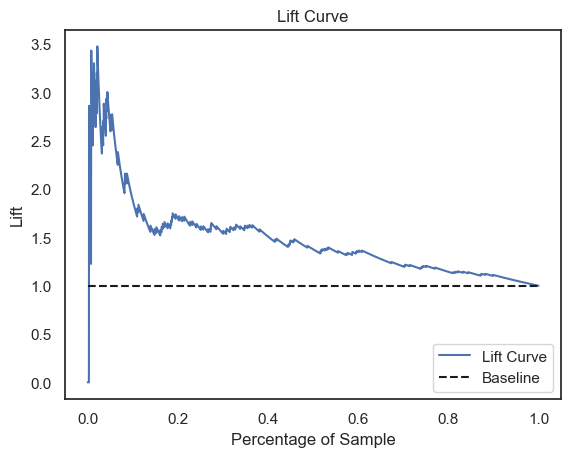

In [132]:
lgbm_eval.plot_lift()

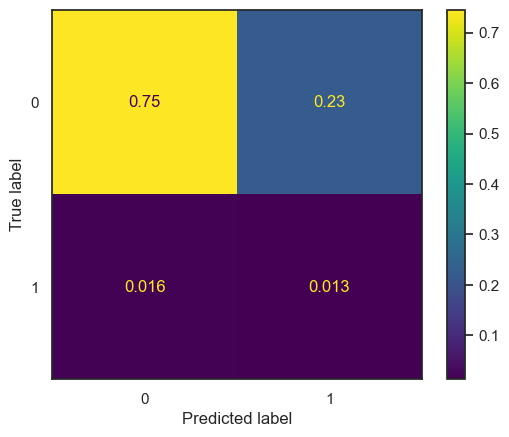

In [116]:
lgbm_eval.plot_confusion_matrix(normalize='all')

In [135]:
np.bincount(y_train)

array([14185,   370])

In [140]:
scale_pos_weight = 14185/370

In [141]:
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        **study.best_params
        , scale_pos_weight=scale_pos_weight
        # , is_unbalance=True
        , random_state=42
    ))
])

lgbm_pipeline.fit(X_train, y_train)

print(classification_report(y_val, lgbm_pipeline.predict(X_val)))
lgbm_eval = ModelEvaluator(lgbm_pipeline, X_val, y_val)
lgbm_eval.evaluate()

              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86      3533
         1.0       0.05      0.44      0.10       106

    accuracy                           0.76      3639
   macro avg       0.52      0.61      0.48      3639
weighted avg       0.95      0.76      0.84      3639



,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,60.56,5.42,44.34,870.63,9.66,75.85


In [142]:
th = 0.5
y_probas = lgbm_pipeline.predict_proba(X_val)[:, 1]
ypred = (y_probas > th).astype(int)

<Axes: ylabel='Count'>

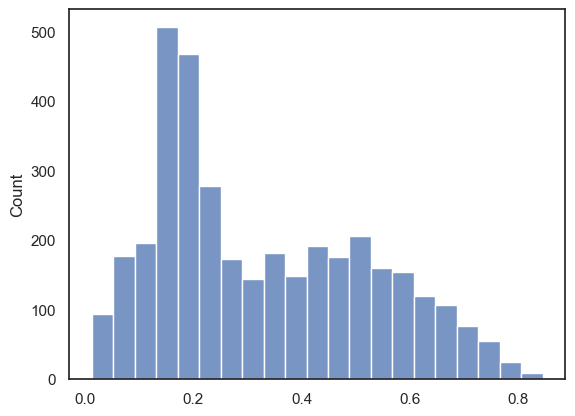

In [143]:
import seaborn as sns
sns.histplot(x=y_probas)

Precision: dos clientes que previmos como PRO, quantos realmente são

Recall: dos clientes que realmente são PRO, quantos conseguimos identificar

F1 : Bom para avaliar o trade-off entre falsos positivos e falsos negativos. Dá mais peso para a classe minoritária (PRO)

Lift

Mostra quantas vezes seu modelo é melhor que uma seleção aleatória
Muito útil para problemas de negócio como este


Vamos analisar o significado de cada métrica no contexto do Cartola FC para tomar essa decisão:

**Precision (Precisão)**
- Dos clientes que o modelo previu como potenciais PRO, quantos realmente se tornaram PRO
- Alta precision significa menos desperdício de recursos em ações de marketing
- Fórmula: Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Positivos)

**Recall (Revocação/Sensibilidade)**
- Dos clientes que realmente se tornaram PRO, quantos conseguimos identificar
- Alto recall significa capturar a maior quantidade possível de clientes potenciais
- Fórmula: Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos)

Para o Cartola FC, eu recomendaria **priorizar Recall** pelos seguintes motivos:

1. **Modelo de Negócio**
   - Cliente PRO gera receita recorrente
   - Perder um potencial cliente PRO (falso negativo) significa perder receita garantida
   - O custo de abordar um cliente free que não se converte (falso positivo) é relativamente baixo

2. **Estratégia de Marketing**
   - Melhor abordar mais clientes potenciais, mesmo que alguns não convertam
   - O custo de comunicação/campanha provavelmente é baixo (emails, notificações no app)
   - Você pode criar diferentes níveis de ações baseado no score de propensão

3. **Competitividade do Mercado**
   - Se um cliente com alto potencial não é abordado, ele pode:
     - Continuar como free indefinidamente
     - Migrar para concorrentes
     - Perder interesse no produto

4. **Aprendizado do Negócio**
   - Alto recall permite entender melhor o comportamento dos diferentes perfis
   - Ajuda a refinar futuras campanhas e o próprio modelo

Recomendações práticas:

1. Use threshold mais baixo na classificação para aumentar o recall
2. Monitore o lift nas diferentes faixas de score
3. Crie níveis de ações diferentes baseado no score:
   - Top 10%: ação mais agressiva
   - 10-30%: ação moderada
   - 30-50%: ação leve

Você concorda com essa análise? Tem alguma informação adicional sobre o custo de aquisição ou valor do cliente PRO que devemos considerar?